In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import pywt
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.metrics import r2_score

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['font.sans-serif'] = ['SimHei']

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')


## 加载数据

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_10624\3199085973.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [3]:
len(Battery['B0005'][0]), len(Battery['B0005'][1])

(168, 168)

## 画出数据

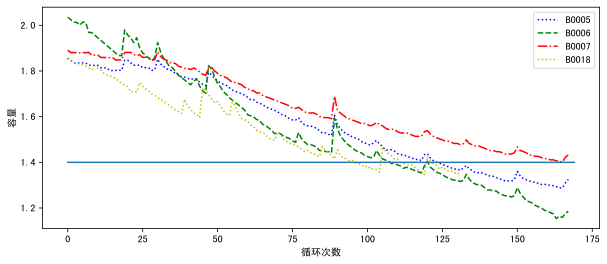

In [4]:
%matplotlib inline

def matplot_battery_list(battery_data_list):
    color_list = ['b:', 'g--', 'r-.', 'y:']
    # 1.创建画布
    plt.figure(figsize=(10, 4), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')

    # 2.绘制折线图
    for index, data in enumerate(battery_data_list):
        plt.plot([i for i in range(len(battery_data_list[index]))], battery_data_list[index], color_list[index])

    plt.plot([i for i in range(170)], [1.4] * 170)

    # 图例
    plt.legend([name for name in Battery_list])

Battery_data_list = [Battery['B0005'][1], Battery['B0006'][1], Battery['B0007'][1], Battery['B0018'][1]]
matplot_battery_list(Battery_data_list)

## 创建评估指标函数

In [60]:
threshold_xi = [0.7, 0.7, 0.75, 0.7]

# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    r2 = r2_score(y_test, y_predict)
    return mae, rmse, r2

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4，所以设置为1.5，即第126次循环达到阈值1.5
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    # print('y_test len is', len(y_test))
    # print('y_predict len is', len(y_predict))
    # print('threshold is', threshold)
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    # print('true_re is', true_re)
    return abs(true_re - pred_re) / true_re, abs(true_re - pred_re)

relative_error(Battery['B0005'][1], Battery['B0005'][1], 1.4)

(0.0, 0)

## 小波降噪 level=1

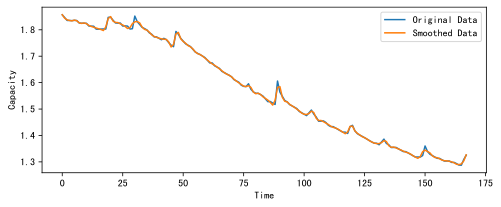

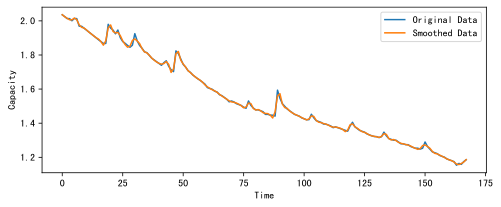

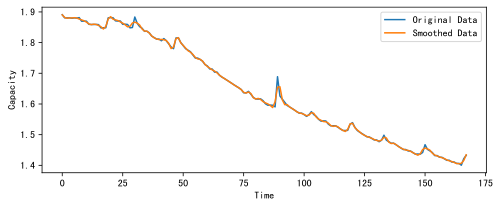

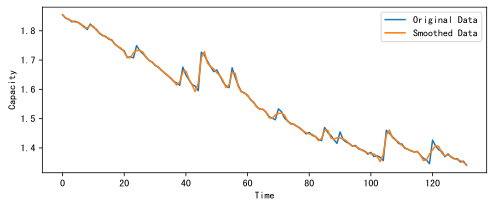

y_test len is 168
y_predict len is 168
threshold is 1.4
true_re is 125
battery_index:0    , MAE:0.0030 , RMSE:0.0049 , RE:0.0000
y_test len is 168
y_predict len is 168
threshold is 1.4
true_re is 109
battery_index:1    , MAE:0.0047 , RMSE:0.0077 , RE:0.0000
y_test len is 168
y_predict len is 168
threshold is 1.4
true_re is 168
battery_index:2    , MAE:0.0026 , RMSE:0.0049 , RE:0.0000
y_test len is 132
y_predict len is 132
threshold is 1.4
true_re is 97
battery_index:3    , MAE:0.0054 , RMSE:0.0084 , RE:0.0000
4


In [55]:
# 小波降噪函数
def wavelet_smoothing(data, wavelet='db4', level=1):
    # 小波分解
    coeffs = pywt.wavedec(data, wavelet, level=level)
    
    # 阈值处理（可根据需求调整阈值）
    threshold = 2.5
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]), mode='soft')
    
    # 小波重构
    smoothed_data = pywt.waverec(coeffs, wavelet)
    
    return smoothed_data

wd_battery_data_list = []
for b_data in Battery_data_list:
    # 原始的时间序列数据
    original_data = b_data

    smoothed_data = wavelet_smoothing(original_data)
    wd_battery_data_list.append(smoothed_data)

    # 可视化原始数据和平滑后的数据
    fig = plt.figure(figsize=(8, 3), dpi=80)
    plt.plot(original_data, label='Original Data')
    plt.plot(smoothed_data, label='Smoothed Data')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Capacity')
    display(fig)
    plt.close()

# 检查下 小波降噪后的数据的指标评分
rate_i = 0
for o_data, k_data in zip(Battery_data_list, wd_battery_data_list):
    mae, rmse, r2 = evaluation(o_data, k_data)
    re, ae = relative_error(o_data, k_data, threshold=2 * 0.7)
    battery_index = rate_i
    rate_i+=1
    print('battery_index:{:<4d} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(battery_index, mae, rmse, re))

print(len(wd_battery_data_list))

## 构建训练序列数据

In [7]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size
# train_y 的维度是 window_size
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + 1:i + window_size + 1]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_list, battery_i, window_size=16):
    data_sequence = Battery[Battery_list[battery_i]][1]
    train_data = data_sequence[startPreIndex: window_size + startPreIndex]
    test_data = data_sequence[startPreIndex + window_size:]
    
    current_battery_train_data = data_sequence[:startPreIndex]
    # print('current_battery_train_data', len(current_battery_train_data))
    
    train_x, train_y = None, None
    for i, v in enumerate(data_list):
        if i != battery_i:
            data_x, data_y = build_seq(text=v, window_size=window_size)
            # print('len(data_x)', len(data_x))
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
                
    data_x, data_y = build_seq(text=current_battery_train_data, window_size=window_size)
    # print('data_x len is', len(data_x))
    if (len(data_x) > 0):
        train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 检验 train_iter 数据是否正确

In [73]:
startPreIndex = 50

train_x, train_y, train_data, test_data = get_train_test_data(wd_battery_data_list, 3, window_size=64)
print('train_data len is', len(train_data))
print('test_data len is', len(test_data))
# train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, 0, window_size=16)

train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 2, is_train=False)

# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for x, y in train_iter:
        print(x.shape)
        print(y.shape)
        
        print(x)
        print(y)
        break



validate_train_iter(train_iter)

train_data len is 64
test_data len is 18
torch.Size([2, 64])
torch.Size([2, 64])
tensor([[1.8571, 1.8439, 1.8376, 1.8352, 1.8337, 1.8367, 1.8342, 1.8263, 1.8240,
         1.8260, 1.8231, 1.8166, 1.8125, 1.8098, 1.8066, 1.8041, 1.8010, 1.7972,
         1.8107, 1.8429, 1.8498, 1.8327, 1.8278, 1.8272, 1.8224, 1.8183, 1.8125,
         1.8048, 1.8081, 1.8232, 1.8302, 1.8313, 1.8262, 1.8105, 1.8016, 1.7987,
         1.7908, 1.7808, 1.7746, 1.7714, 1.7681, 1.7656, 1.7643, 1.7636, 1.7542,
         1.7349, 1.7448, 1.7845, 1.7899, 1.7659, 1.7558, 1.7489, 1.7402, 1.7356,
         1.7275, 1.7164, 1.7096, 1.7064, 1.7005, 1.6929, 1.6856, 1.6776, 1.6708,
         1.6655],
        [1.8439, 1.8376, 1.8352, 1.8337, 1.8367, 1.8342, 1.8263, 1.8240, 1.8260,
         1.8231, 1.8166, 1.8125, 1.8098, 1.8066, 1.8041, 1.8010, 1.7972, 1.8107,
         1.8429, 1.8498, 1.8327, 1.8278, 1.8272, 1.8224, 1.8183, 1.8125, 1.8048,
         1.8081, 1.8232, 1.8302, 1.8313, 1.8262, 1.8105, 1.8016, 1.7987, 1.7908,
         1

## 绘制 out 和  tgt_y的对比图

In [9]:
# 绘制 out  tgt_y的对比图
def matlab_make(out, tgt_y):
    color_list = ['b:', 'g:']
    # 1.创建画布
    fig = plt.figure(figsize=(7, 2), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')
    
    data_list = [
        {
            'name': 'out',
            'x': [i for i in range(len(out))],
            'y': out
        },
        {
            'name': 'tgt_y',
            'x': [i for i in range(len(tgt_y))],
            'y': tgt_y
        }
    ]

    # 2.绘制折线图
    for data,color in zip(data_list, color_list):
        plt.plot(data['x'], data['y'], color)


    # 图例
    plt.legend([data['name'] for data in data_list])
    
    display(fig)
    plt.close() 

# out_t = [1,2,3,4,5,6,7,8,9,10]
# tgt_y_t = [11,21,31,41,51,61,71,81,91,110]

# matlab_make(out_t, tgt_y_t)

## 2维数据的残差1D卷积网络

In [22]:
# 残差网络
class Residual1D(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        conv1_out = self.conv1(X)
        print('conv1_out shape is', conv1_out.shape)
        
        bn1_out = self.bn1(conv1_out)
        print('bn1_out shape is', bn1_out.shape)
        
        relu1_out = F.relu(bn1_out)
        print('relu1_out shape is', relu1_out.shape)
        
        conv2_out = self.conv2(relu1_out)
        print('conv2_out shape is', conv2_out.shape)
        
        bn2_out = self.bn2(conv2_out)
        print('bn2_out shape is', bn2_out.shape)
        
        X = torch.cat([X, X], dim=1)
        print('cat X shape is', X.shape)
        
        Y = X + bn2_out
        print('Y shape is', Y.shape)
        return F.relu(Y)


    
blk = Residual1D(32, 64, 3)
X = torch.rand(50, 32, 16) # 50是批次大小，32是d_model，16是窗口大小
Y = blk(X)
# Y = blk(Y)
Y.shape

conv1_out shape is torch.Size([50, 64, 16])
bn1_out shape is torch.Size([50, 64, 16])
relu1_out shape is torch.Size([50, 64, 16])
conv2_out shape is torch.Size([50, 64, 16])
bn2_out shape is torch.Size([50, 64, 16])
cat X shape is torch.Size([50, 64, 16])
Y shape is torch.Size([50, 64, 16])


torch.Size([50, 64, 16])

## 2维数据的残差1D卷积网络 实现多层

In [38]:
# 残差网络
class Residual1D(nn.Module):
    def __init__(self, input_channels, kernel_size=3, strides=1):
        super().__init__()
        
        hidden_dim = input_channels * 2
        
        self.conv1 = nn.Conv1d(input_channels, hidden_dim, kernel_size=kernel_size, stride=strides, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=strides, padding=1)
        self.conv3 = nn.Conv1d(hidden_dim, input_channels, kernel_size=kernel_size, stride=strides, padding=1)
        
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(input_channels)

    def forward(self, X):
        conv1_out = self.conv1(X)
        # print('conv1_out shape is', conv1_out.shape)

        bn1_out = self.bn1(conv1_out)
        # print('bn1_out shape is', bn1_out.shape)

        relu1_out = F.relu(bn1_out)
        # print('relu1_out shape is', relu1_out.shape)

        conv2_out = self.conv2(relu1_out)
        # print('conv2_out shape is', conv2_out.shape)

        bn2_out = self.bn2(conv2_out)
        # print('bn2_out shape is', bn2_out.shape)

        relu2_out = F.relu(bn2_out)
        # print('relu2_out shape is', relu2_out.shape)

        conv3_out = self.conv3(relu2_out)
        # print('conv3_out shape is', conv3_out.shape)

        bn3_out = self.bn3(conv3_out)
        # print('bn3_out shape is', bn3_out.shape)


        Y = X + bn3_out
        # print('Y shape is', Y.shape)
        return F.relu(Y)

def resnet_block(input_channels, num_layers=2, kernel_size=3):
    blk = []
    for i in range(num_layers):
        blk.append(Residual1D(input_channels=input_channels, kernel_size=kernel_size))
    return blk
    
res_blks = resnet_block(32, 2)
X = torch.rand(50, 32, 16) # 50是批次大小，32是d_model，16是窗口大小
blks_model = nn.Sequential(*res_blks)
Y = blks_model(X)
Y.shape

torch.Size([50, 32, 16])

## 随机种子

In [14]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 位置编码

In [15]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

## 搭建模型 此处代码是模板 无需运行

In [73]:
class Net(nn.Module):

    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, dim_feedforward=32, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        self.rcnn = Residual1D(d_model, d_model * 2, kernel_size=kernel_size)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        

        # 对 x 进行编码
        # x = x.reshape(x.shape[0], x.shape[1], 1)
        x = x.reshape(x.shape[0], 1, x.shape[1])
        
        # x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
    
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model * 2)

        out = self.predictor(out)
    
        return out

## 测试模型的输出形状 此处代码是模板 无需运行

In [74]:
# 测试模型的输出形状
net = Net(d_model=16).to(device)

# src = torch.LongTensor([[0, 3, 4, 5, 6, 1, 2, 2]])
x = torch.ones((50, 16), dtype=torch.float32).to(device)

out = net(x)
print(out.size())

torch.Size([50, 1, 1])


## 一个批次的训练函数

In [18]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x / Rated_Capacity, (-1, x.shape[-1])).type(torch.float32)
        y = torch.reshape(y / Rated_Capacity, (-1, y.shape[-1])).type(torch.float32)
        
        x, y = x.to(device), y.to(device)
 
        out = net(x)
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [76]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)

        if (len(rmse_epoch_list) == 0 or (rmse_epoch_list[-1] < rmse)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]

## 预测函数

In [39]:
def predict(net, train_data, test_data, Rated_Capacity):
    net = net.eval()
    
    x = train_data.copy()
    x = np.array(x)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    x = torch.reshape(x / Rated_Capacity, (1, -1)) # shape: (batch_size, input_size)
    
    pre_list = []
    while len(pre_list) < len(test_data):
        
        out = net(x)
        x = torch.cat([x[:, 1:], out[:, -1]], dim=1)
        
        pred = out.reshape(-1)
        
        pred_next_point = pred.cpu().data.numpy()[-1] * Rated_Capacity
        
        pre_list.append(pred_next_point)
        
    return pre_list

## 以rmse评价指标为判断函数 开始训练

In [41]:
# 残差网络
class Residual1D(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        conv1_out = self.conv1(X)
        
        bn1_out = self.bn1(conv1_out)
        
        relu1_out = F.relu(bn1_out)
        
        conv2_out = self.conv2(relu1_out)
        
        bn2_out = self.bn2(conv2_out)
        
        X = torch.cat([X, X], dim=1)
        
        Y = X + bn2_out
        return F.relu(Y)

def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x / Rated_Capacity, (-1, x.shape[-1])).type(torch.float32)
        y = torch.reshape(y / Rated_Capacity, (-1, y.shape[-1])).type(torch.float32)
        
        x, y = x.to(device), y.to(device)
 
        out = net(x)
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

class Net(nn.Module):

    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, dim_feedforward=32, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        self.rcnn = Residual1D(d_model, d_model * 2, kernel_size=kernel_size)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        
        self.dense = nn.Linear(d_model * 2, d_model)
        
        self.predictor = nn.Linear(d_model, 1)

    def forward(self, x):

        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model * 2)

        out = self.dense(out)
        out = self.predictor(out)
    
        return out

def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * threshold_xi[i])
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = rmse
            lastSum = rmse_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f} , currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 模型参数
d_model = 16
nhead = 4
num_encoder_layers = 3
dim_feedforward = 64
kernel_size = 5

# 训练参数
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 1000
window_size = 32
startPreCycle = 80


startPreIndex = startPreCycle - 1

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(wd_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward, kernel_size=kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're min: {np.array(re_s).min()}')
    print(f'mae min: {np.array(mae_s).min()}')
    print(f'rmse min: {np.array(rmse_s).min()}')
    print(f'r2 max: {np.array(r2_s).max()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).min())
    mae_seed_all.append(np.array(mae_s).min())
    rmse_seed_all.append(np.array(rmse_s).min())
    r2_seed_all.append(np.array(r2_s).max())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
test_data len is [1.433445432156979, 1.4333958900838095, 1.42806487344776, 1.4229203181741186, 1.417429032731308, 1.412409228794446, 1.412578792940193, 1.4075983731469897, 1.4333920485221476, 1.4382550176792908, 1.4173547174485526, 1.406981663677643, 1.4012037783587625, 1.3967008232726328, 1.391284788852726, 1.3862287677978349, 1.3804366761974138, 1.3752364150256224, 1.3705128024895008, 1.3705085566270399, 1.3647355108681518, 1.375392016895762, 1.3861115151535393, 1.3698500035838939, 1.3647827949260758, 1.3543220466259964, 1.3546417018378962, 1.3547039213192407, 1.349314997503458, 1.3441891937970554, 1.3389913790695755, 1.3389145230206971, 1.3340066759761655, 1.3286444309174914, 1.3231708992276219, 1.3181691588445197, 1.3184664436640334, 1.318293040102702, 1.323872422244268, 1.3601216766554785, 1.3395306867947354, 1.3290286565120697, 1.3236741274998955, 1.318

TypeError: __init__() got multiple values for argument 'kernel_size'

## （此结果有很重要的意义，需要保留）网格搜索window_size 以rmse评价指标为判断函数 

In [74]:
class Net(nn.Module):
    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, num_res_layers=2, dim_feedforward=32, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        res_blks = resnet_block(d_model, num_res_layers, kernel_size)
        self.rcnn = nn.Sequential(*res_blks)
        
        self.dense = nn.Linear(d_model, d_model * 2)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model)

        out = self.dense(out)
        out = self.predictor(out)
    
        return out

# 测试模型的输出形状
# net = Net(d_model=16).to(device)
# x = torch.ones((50, 16), dtype=torch.float32).to(device)
# out = net(x)
# print(out.size())

# 总的训练函数
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, ae_epoch_list, r2_epoch_list = [], [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        
        cat_test_y = Battery[Battery_list[i]][1][:startPreIndex] + train_data + test_y
        cat_pre_list = Battery[Battery_list[i]][1][:startPreIndex] + train_data + pre_list
        re, ae = relative_error(cat_test_y, cat_pre_list, threshold=Rated_Capacity * threshold_xi[i])
        
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = rmse
            lastSum = rmse_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed:{}, 测试集:{}, epoch:{:<4d}, loss:{:<6.10f}, MAE:{:<6.4f}, RMSE:{:<6.4f}, RE:{:<6.4f}, AE:{:<6.4f}, R2:{:<6.4f}, currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, ae, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            ae_epoch_list.append(ae)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], ae_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 模型参数
d_model = 16
nhead = 4
num_encoder_layers = 2
dim_feedforward = 64
kernel_size = 3
num_res_layers = 2

# 训练参数
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 1000
startPreCycle = 50


startPreIndex = startPreCycle - 1

# window_size 的网格搜索数组
window_size_list = [4, 8, 16, 32, 64]

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, ae_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], [], []
for window_size_i in range(5):
    print('*******************************************************************************************************************')
    # window_size = window_size_list[window_size_i]
    window_size = window_size_list[window_size_i]
    print('当前的 window_size 为', window_size)
    seed = 13
    setup_seed(seed)
    mae_s, rmse_s, re_s, ae_s, r2_s = [], [], [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(wd_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, num_res_layers=num_res_layers,
                  dim_feedforward=dim_feedforward, kernel_size=kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, ae, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        ae_s.append(ae)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('ae_s', ae_s)
    print('---------------------------------')
    print(f're min: {np.array(re_s).min()}')
    print(f'ae min: {np.array(ae_s).min()}')
    print(f'mae min: {np.array(mae_s).min()}')
    print(f'rmse min: {np.array(rmse_s).min()}')
    print(f'r2 max: {np.array(r2_s).max()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).min())
    ae_seed_all.append(np.array(ae_s).min())
    mae_seed_all.append(np.array(mae_s).min())
    rmse_seed_all.append(np.array(rmse_s).min())
    r2_seed_all.append(np.array(r2_s).max())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'ae min: {np.array(ae_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 window_size 为 4
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.7041751146, MAE:1.1349, RMSE:1.1431, RE:0.5680, AE:71.0000, R2:-79.8139, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.3274615407, MAE:0.8999, RMSE:0.9091, RE:0.5680, AE:71.0000, R2:-50.1136, currentSum:0.9091
seed:13, 测试集:B0005, epoch:3   , loss:0.2454070300, MAE:0.7625, RMSE:0.7721, RE:0.5680, AE:71.0000, R2:-35.8675, currentSum:0.7721
seed:13, 测试集:B0005, epoch:4   , loss:0.1475784183, MAE:0.6631, RMSE:0.6744, RE:0.5680, AE:71.0000, R2:-27.1314, currentSum:0.6744
seed:13, 测试集:B0005, epoch:5   , loss:0.1181578338, MAE:0.5654, RMSE:0.5771, RE:0.5680, AE:71.0000, R2:-19.6022, currentSum:0.5771
seed:13, 测试集:B0005, epoch:6   , loss:0.0746681392, MAE:0.1718, RMSE:0.2116, RE:0.5600, AE:70.0000, R2:-1.7682, currentSum:0.2116
seed:13, 测试集:B0005, epoch:7   , loss:0.0077578239, MAE:0.10

seed:13, 测试集:B0018, epoch:8   , loss:0.0641809627, MAE:0.0810, RMSE:0.1064, RE:0.4021, AE:39.0000, R2:-0.8680, currentSum:0.1064
seed:13, 测试集:B0018, epoch:9   , loss:0.0464663766, MAE:0.0673, RMSE:0.0779, RE:0.3608, AE:35.0000, R2:-0.0008, currentSum:0.0779
seed:13, 测试集:B0018, epoch:248 , loss:0.0011932156, MAE:0.0428, RMSE:0.0522, RE:0.1443, AE:14.0000, R2:0.5504, currentSum:0.0522
seed:13, 测试集:B0018, epoch:299 , loss:0.0003919727, MAE:0.0448, RMSE:0.0504, RE:0.2577, AE:25.0000, R2:0.5815, currentSum:0.0504
seed:13, 测试集:B0018, epoch:363 , loss:0.0004625869, MAE:0.0375, RMSE:0.0469, RE:0.0309, AE:3.0000, R2:0.6367, currentSum:0.0469
seed:13, 测试集:B0018, epoch:452 , loss:0.0003853870, MAE:0.0420, RMSE:0.0462, RE:0.0619, AE:6.0000, R2:0.6485, currentSum:0.0462
seed:13, 测试集:B0018, epoch:458 , loss:0.0003228964, MAE:0.0346, RMSE:0.0427, RE:0.0412, AE:4.0000, R2:0.6995, currentSum:0.0427
seed:13, 测试集:B0018, epoch:467 , loss:0.0005730779, MAE:0.0344, RMSE:0.0413, RE:0.0412, AE:4.0000, R2:0.71

seed:13, 测试集:B0006, epoch:397 , loss:0.0001622402, MAE:0.0581, RMSE:0.0722, RE:0.1284, AE:14.0000, R2:0.6686, currentSum:0.0722
seed:13, 测试集:B0006, epoch:410 , loss:0.0005868452, MAE:0.0585, RMSE:0.0718, RE:0.0826, AE:9.0000, R2:0.6725, currentSum:0.0718
seed:13, 测试集:B0006, epoch:429 , loss:0.0003762009, MAE:0.0555, RMSE:0.0670, RE:0.0917, AE:10.0000, R2:0.7147, currentSum:0.0670
seed:13, 测试集:B0006, epoch:436 , loss:0.0001565572, MAE:0.0533, RMSE:0.0665, RE:0.1284, AE:14.0000, R2:0.7195, currentSum:0.0665
seed:13, 测试集:B0006, epoch:441 , loss:0.0001107341, MAE:0.0538, RMSE:0.0658, RE:0.1193, AE:13.0000, R2:0.7246, currentSum:0.0658
seed:13, 测试集:B0006, epoch:442 , loss:0.0001249281, MAE:0.0510, RMSE:0.0642, RE:0.0642, AE:7.0000, R2:0.7384, currentSum:0.0642
seed:13, 测试集:B0006, epoch:481 , loss:0.0001544049, MAE:0.0496, RMSE:0.0637, RE:0.0734, AE:8.0000, R2:0.7419, currentSum:0.0637
seed:13, 测试集:B0006, epoch:492 , loss:0.0001331579, MAE:0.0487, RMSE:0.0637, RE:0.1009, AE:11.0000, R2:0.742

seed:13, 测试集:B0018, epoch:132 , loss:0.0009412417, MAE:0.0170, RMSE:0.0219, RE:0.0412, AE:4.0000, R2:0.8917, currentSum:0.0219
seed:13, 测试集:B0018, epoch:146 , loss:0.0010104707, MAE:0.0166, RMSE:0.0213, RE:0.0825, AE:8.0000, R2:0.8970, currentSum:0.0213
---------------------------------
re_s [0.024, 0.01834862385321101, 0.05555555555555555, 0.08247422680412371]
ae_s [3, 2, 7, 8]
---------------------------------
re min: 0.01834862385321101
ae min: 2
mae min: 0.012995862031905088
rmse min: 0.017812782337573517
r2 max: 0.9778006131282945
---------------------------------
*******************************************************************************************************************
当前的 window_size 为 16
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.5359127522, MAE:0.6617, RMSE:0.6712, RE:0.4720, AE:59.0000, R2:-39.4901, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.2355351150, MAE:0.6532, RMSE:0.6631, RE:0.4720, AE:59.0000, R2:-38.5241, currentSum:0.6631
s

seed:13, 测试集:B0007, epoch:164 , loss:0.0014792522, MAE:0.0215, RMSE:0.0250, RE:0.0873, AE:11.0000, R2:0.9071, currentSum:0.0250
seed:13, 测试集:B0007, epoch:597 , loss:0.0001834748, MAE:0.0203, RMSE:0.0244, RE:0.0238, AE:3.0000, R2:0.9113, currentSum:0.0244
seed:13, 测试集:B0007, epoch:671 , loss:0.0017540399, MAE:0.0177, RMSE:0.0233, RE:0.0079, AE:1.0000, R2:0.9188, currentSum:0.0233
seed:13, 测试集:B0007, epoch:686 , loss:0.0003548220, MAE:0.0159, RMSE:0.0209, RE:0.0238, AE:3.0000, R2:0.9349, currentSum:0.0209
seed:13, 测试集:B0007, epoch:709 , loss:0.0009704036, MAE:0.0152, RMSE:0.0206, RE:0.0159, AE:2.0000, R2:0.9367, currentSum:0.0206
seed:13, 测试集:B0007, epoch:757 , loss:0.0002734071, MAE:0.0145, RMSE:0.0193, RE:0.0238, AE:3.0000, R2:0.9443, currentSum:0.0193
seed:13, 测试集:B0007, epoch:816 , loss:0.0004904224, MAE:0.0148, RMSE:0.0191, RE:0.0000, AE:0.0000, R2:0.9458, currentSum:0.0191
seed:13, 测试集:B0007, epoch:830 , loss:0.0001583604, MAE:0.0136, RMSE:0.0176, RE:0.0317, AE:4.0000, R2:0.9537, c

seed:13, 测试集:B0005, epoch:104 , loss:0.0029652875, MAE:0.1060, RMSE:0.1155, RE:0.3440, AE:43.0000, R2:-0.9082, currentSum:0.1155
seed:13, 测试集:B0005, epoch:105 , loss:0.0023127731, MAE:0.1044, RMSE:0.1139, RE:0.3440, AE:43.0000, R2:-0.8559, currentSum:0.1139
seed:13, 测试集:B0005, epoch:108 , loss:0.0033743584, MAE:0.1027, RMSE:0.1121, RE:0.3440, AE:43.0000, R2:-0.8001, currentSum:0.1121
seed:13, 测试集:B0005, epoch:109 , loss:0.0021313240, MAE:0.0998, RMSE:0.1090, RE:0.3440, AE:43.0000, R2:-0.7010, currentSum:0.1090
seed:13, 测试集:B0005, epoch:137 , loss:0.0016479156, MAE:0.1012, RMSE:0.1086, RE:0.3440, AE:43.0000, R2:-0.6880, currentSum:0.1086
seed:13, 测试集:B0005, epoch:138 , loss:0.0016812875, MAE:0.0824, RMSE:0.0896, RE:0.3440, AE:43.0000, R2:-0.1498, currentSum:0.0896
seed:13, 测试集:B0005, epoch:168 , loss:0.0015803910, MAE:0.0817, RMSE:0.0870, RE:0.3440, AE:43.0000, R2:-0.0837, currentSum:0.0870
seed:13, 测试集:B0005, epoch:194 , loss:0.0015784288, MAE:0.0760, RMSE:0.0801, RE:0.3040, AE:38.0000

seed:13, 测试集:B0007, epoch:14  , loss:0.0472166426, MAE:0.2736, RMSE:0.2981, RE:0.3016, AE:38.0000, R2:-18.9737, currentSum:0.2981
seed:13, 测试集:B0007, epoch:15  , loss:0.0344702192, MAE:0.0328, RMSE:0.0432, RE:0.2063, AE:26.0000, R2:0.5805, currentSum:0.0432
seed:13, 测试集:B0007, epoch:95  , loss:0.0033705113, MAE:0.0367, RMSE:0.0431, RE:0.0397, AE:5.0000, R2:0.5827, currentSum:0.0431
seed:13, 测试集:B0007, epoch:98  , loss:0.0031152819, MAE:0.0356, RMSE:0.0419, RE:0.1270, AE:16.0000, R2:0.6054, currentSum:0.0419
seed:13, 测试集:B0007, epoch:102 , loss:0.0027078853, MAE:0.0354, RMSE:0.0416, RE:0.0397, AE:5.0000, R2:0.6112, currentSum:0.0416
seed:13, 测试集:B0007, epoch:103 , loss:0.0031200829, MAE:0.0345, RMSE:0.0408, RE:0.1190, AE:15.0000, R2:0.6257, currentSum:0.0408
seed:13, 测试集:B0007, epoch:107 , loss:0.0032543945, MAE:0.0337, RMSE:0.0397, RE:0.0873, AE:11.0000, R2:0.6455, currentSum:0.0397
seed:13, 测试集:B0007, epoch:109 , loss:0.0026713081, MAE:0.0334, RMSE:0.0395, RE:0.1190, AE:15.0000, R2:0.

seed:13, 测试集:B0005, epoch:1   , loss:0.4742473364, MAE:1.3416, RMSE:1.3443, RE:0.0880, AE:11.0000, R2:-998.7790, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.3816621602, MAE:1.3286, RMSE:1.3317, RE:0.0880, AE:11.0000, R2:-980.0820, currentSum:1.3317
seed:13, 测试集:B0005, epoch:3   , loss:0.2957921624, MAE:1.2420, RMSE:1.2455, RE:0.0880, AE:11.0000, R2:-857.2278, currentSum:1.2455
seed:13, 测试集:B0005, epoch:4   , loss:0.1872318387, MAE:1.0349, RMSE:1.0376, RE:0.0880, AE:11.0000, R2:-594.5834, currentSum:1.0376
seed:13, 测试集:B0005, epoch:5   , loss:0.1342269480, MAE:0.8320, RMSE:0.8336, RE:0.0880, AE:11.0000, R2:-383.4633, currentSum:0.8336
seed:13, 测试集:B0005, epoch:6   , loss:0.1096031740, MAE:0.6994, RMSE:0.7013, RE:0.0880, AE:11.0000, R2:-271.0799, currentSum:0.7013
seed:13, 测试集:B0005, epoch:7   , loss:0.0711016431, MAE:0.5745, RMSE:0.5768, RE:0.0880, AE:11.0000, R2:-183.0785, currentSum:0.5768
seed:13, 测试集:B0005, epoch:8   , loss:0.0532035492, MAE:0.4547, RMSE:0.4575, RE:0.08

seed:13, 测试集:B0007, epoch:27  , loss:0.0131392591, MAE:0.0444, RMSE:0.0554, RE:0.0952, AE:12.0000, R2:-1.1097, currentSum:0.0554
seed:13, 测试集:B0007, epoch:28  , loss:0.0131309461, MAE:0.0389, RMSE:0.0496, RE:0.0952, AE:12.0000, R2:-0.6884, currentSum:0.0496
seed:13, 测试集:B0007, epoch:29  , loss:0.0116819739, MAE:0.0372, RMSE:0.0476, RE:0.0952, AE:12.0000, R2:-0.5577, currentSum:0.0476
seed:13, 测试集:B0007, epoch:30  , loss:0.0130569208, MAE:0.0349, RMSE:0.0449, RE:0.0952, AE:12.0000, R2:-0.3845, currentSum:0.0449
seed:13, 测试集:B0007, epoch:31  , loss:0.0114371171, MAE:0.0349, RMSE:0.0448, RE:0.0952, AE:12.0000, R2:-0.3803, currentSum:0.0448
seed:13, 测试集:B0007, epoch:44  , loss:0.0085926903, MAE:0.0352, RMSE:0.0446, RE:0.0952, AE:12.0000, R2:-0.3683, currentSum:0.0446
seed:13, 测试集:B0007, epoch:48  , loss:0.0089115528, MAE:0.0343, RMSE:0.0438, RE:0.0952, AE:12.0000, R2:-0.3189, currentSum:0.0438
seed:13, 测试集:B0007, epoch:49  , loss:0.0077533554, MAE:0.0340, RMSE:0.0433, RE:0.0952, AE:12.0000

## 网格搜索模型超参数 以rmse评价指标为判断函数 开始训练
已经查看到 【当前的参数组合是 d_model:64, nhead:8, num_encoder_layers:4, dim_feedforward:32, num_res_layers:8】之前的数据，最好的结果是rmse min: 0.01020591818875075

In [75]:
class Net(nn.Module):
    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, num_res_layers=2, dim_feedforward=32, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        res_blks = resnet_block(d_model, num_res_layers, kernel_size)
        self.rcnn = nn.Sequential(*res_blks)
        
        self.dense = nn.Linear(d_model, d_model * 2)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model)

        out = self.dense(out)
        out = self.predictor(out)
    
        return out

# 测试模型的输出形状
# net = Net(d_model=16).to(device)
# x = torch.ones((50, 16), dtype=torch.float32).to(device)
# out = net(x)
# print(out.size())

# 总的训练函数
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, ae_epoch_list, r2_epoch_list = [], [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        
        cat_test_y = Battery[Battery_list[i]][1][:startPreIndex] + train_data + test_y
        cat_pre_list = Battery[Battery_list[i]][1][:startPreIndex] + train_data + pre_list
        re, ae = relative_error(cat_test_y, cat_pre_list, threshold=Rated_Capacity * threshold_xi[i])
        
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = rmse
            lastSum = rmse_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed:{}, 测试集:{}, epoch:{:<4d}, loss:{:<6.10f}, MAE:{:<6.4f}, RMSE:{:<6.4f}, RE:{:<6.4f}, AE:{:<6.4f}, R2:{:<6.4f}, currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, ae, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            ae_epoch_list.append(ae)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], ae_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 模型参数
# d_model = 16
# nhead = 4
# num_encoder_layers = 2
# dim_feedforward = 64
# kernel_size = 3
# num_res_layers = 2

# 模型参数 数组 用于网格搜索
d_model_list = [16, 32, 64]
nhead = [2, 4, 8]
num_encoder_layers = [2, 4, 8]
dim_feedforward = [32, 64, 128]
kernel_size = 3
num_res_layers = [2, 4, 8]

# 训练参数
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 1000
startPreCycle = 80
window_size = 16

startPreIndex = startPreCycle - 1

def main_grad_search(d_model, nhead, num_encoder_layers, dim_feedforward, num_res_layers):
    print('*******************************************************************************************************************')
    print(f'当前的参数组合是 d_model:{d_model}, nhead:{nhead}, num_encoder_layers:{num_encoder_layers}, dim_feedforward:{dim_feedforward}, num_res_layers:{num_res_layers}')
    seed = 13
    setup_seed(seed)
    mae_s, rmse_s, re_s, ae_s, r2_s = [], [], [], [], []
    for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(wd_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, num_res_layers=num_res_layers,
                  dim_feedforward=dim_feedforward, kernel_size=kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, ae, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        ae_s.append(ae)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('ae_s', ae_s)
    print('---------------------------------')
    print(f're min: {np.array(re_s).min()}')
    print(f'ae min: {np.array(ae_s).min()}')
    print(f'mae min: {np.array(mae_s).min()}')
    print(f'rmse min: {np.array(rmse_s).min()}')
    print(f'r2 max: {np.array(r2_s).max()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).min())
    ae_seed_all.append(np.array(ae_s).min())
    mae_seed_all.append(np.array(mae_s).min())
    rmse_seed_all.append(np.array(rmse_s).min())
    r2_seed_all.append(np.array(r2_s).max())


# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, ae_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], [], []
for d_model in [16, 32, 64]:
    for nhead in [2, 4, 8]:
        for num_encoder_layers in [2, 4, 8]:
            for dim_feedforward in [32, 64, 128]:
                for num_res_layers in [2, 4, 8]:
                    main_grad_search(d_model, nhead, num_encoder_layers, dim_feedforward, num_res_layers)
                    

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'ae min: {np.array(ae_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的参数组合是 d_model:16, nhead:2, num_encoder_layers:2, dim_feedforward:32, num_res_layers:2
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.6388995051, MAE:1.8254, RMSE:1.8262, RE:0.2320, AE:29.0000, R2:-806.1487, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.4209415317, MAE:1.6470, RMSE:1.6482, RE:0.2320, AE:29.0000, R2:-656.4674, currentSum:1.6482
seed:13, 测试集:B0005, epoch:3   , loss:0.2762383223, MAE:1.3750, RMSE:1.3790, RE:0.2320, AE:29.0000, R2:-459.2342, currentSum:1.3790
seed:13, 测试集:B0005, epoch:4   , loss:0.1894817054, MAE:0.7741, RMSE:0.7772, RE:0.2320, AE:29.0000, R2:-145.2068, currentSum:0.7772
seed:13, 测试集:B0005, epoch:5   , loss:0.1134229600, MAE:0.5567, RMSE:0.5603, RE:0.2320, AE:29.0000, R2:-74.9911, currentSum:0.5603
seed:13, 测试集:B0005, epoch:6   , loss:0.0699350312, MAE:0.4050, RMSE:0.4081, RE:0.2320, AE:29.0000, R2:-39.3093, cur

seed:13, 测试集:B0005, epoch:1   , loss:1.4574338198, MAE:1.8395, RMSE:1.8406, RE:0.2320, AE:29.0000, R2:-818.9588, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:1.0496963263, MAE:1.4698, RMSE:1.4724, RE:0.2320, AE:29.0000, R2:-523.7047, currentSum:1.4724
seed:13, 测试集:B0005, epoch:3   , loss:0.6585481763, MAE:1.1246, RMSE:1.1372, RE:0.2320, AE:29.0000, R2:-311.9616, currentSum:1.1372
seed:13, 测试集:B0005, epoch:4   , loss:0.4521604776, MAE:1.0388, RMSE:1.0737, RE:0.2320, AE:29.0000, R2:-278.0268, currentSum:1.0737
seed:13, 测试集:B0005, epoch:5   , loss:0.2983590961, MAE:0.9272, RMSE:0.9822, RE:0.2320, AE:29.0000, R2:-232.4921, currentSum:0.9822
seed:13, 测试集:B0005, epoch:6   , loss:0.1990803331, MAE:0.7781, RMSE:0.8493, RE:0.2320, AE:29.0000, R2:-173.5683, currentSum:0.8493
seed:13, 测试集:B0005, epoch:7   , loss:0.1453320384, MAE:0.3288, RMSE:0.4252, RE:0.2320, AE:29.0000, R2:-42.7508, currentSum:0.4252
seed:13, 测试集:B0005, epoch:8   , loss:0.1074479669, MAE:0.2145, RMSE:0.2543, RE:0.216

seed:13, 测试集:B0005, epoch:1   , loss:0.3605336845, MAE:0.9731, RMSE:0.9777, RE:0.2320, AE:29.0000, R2:-230.3339, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.2845557928, MAE:0.7388, RMSE:0.7442, RE:0.2320, AE:29.0000, R2:-133.0341, currentSum:0.7442
seed:13, 测试集:B0005, epoch:3   , loss:0.1483467817, MAE:0.4178, RMSE:0.4274, RE:0.2320, AE:29.0000, R2:-43.2088, currentSum:0.4274
seed:13, 测试集:B0005, epoch:4   , loss:0.1063973457, MAE:0.2727, RMSE:0.2877, RE:0.2320, AE:29.0000, R2:-19.0382, currentSum:0.2877
seed:13, 测试集:B0005, epoch:5   , loss:0.0731795281, MAE:0.2003, RMSE:0.2207, RE:0.2320, AE:29.0000, R2:-10.7841, currentSum:0.2207
seed:13, 测试集:B0005, epoch:6   , loss:0.0705803111, MAE:0.0628, RMSE:0.0884, RE:0.2320, AE:29.0000, R2:-0.8920, currentSum:0.0884
seed:13, 测试集:B0005, epoch:7   , loss:0.0504335202, MAE:0.0729, RMSE:0.0855, RE:0.2320, AE:29.0000, R2:-0.7680, currentSum:0.0855
seed:13, 测试集:B0005, epoch:226 , loss:0.0008872560, MAE:0.0732, RMSE:0.0766, RE:0.2400, AE:

seed:13, 测试集:B0005, epoch:5   , loss:0.0956226587, MAE:0.4412, RMSE:0.4428, RE:0.2320, AE:29.0000, R2:-46.4498, currentSum:0.4428
seed:13, 测试集:B0005, epoch:6   , loss:0.0657027066, MAE:0.0855, RMSE:0.0908, RE:0.2160, AE:27.0000, R2:-0.9943, currentSum:0.0908
seed:13, 测试集:B0005, epoch:67  , loss:0.0031628732, MAE:0.0151, RMSE:0.0187, RE:0.0240, AE:3.0000, R2:0.9155, currentSum:0.0187
seed:13, 测试集:B0005, epoch:73  , loss:0.0019884007, MAE:0.0162, RMSE:0.0175, RE:0.0160, AE:2.0000, R2:0.9258, currentSum:0.0175
seed:13, 测试集:B0005, epoch:75  , loss:0.0017015352, MAE:0.0113, RMSE:0.0140, RE:0.0160, AE:2.0000, R2:0.9528, currentSum:0.0140
seed:13, 测试集:B0005, epoch:166 , loss:0.0009412040, MAE:0.0101, RMSE:0.0132, RE:0.0320, AE:4.0000, R2:0.9581, currentSum:0.0132
---------------------------------
re_s [0.032]
ae_s [4]
---------------------------------
re min: 0.032
ae min: 4
mae min: 0.010064314031836035
rmse min: 0.013155771789060572
r2 max: 0.9581122863199963
-------------------------------

seed:13, 测试集:B0005, epoch:3   , loss:0.2786252797, MAE:0.8025, RMSE:0.8075, RE:0.2320, AE:29.0000, R2:-156.7928, currentSum:0.8075
seed:13, 测试集:B0005, epoch:4   , loss:0.1897005886, MAE:0.6798, RMSE:0.6939, RE:0.2320, AE:29.0000, R2:-115.5450, currentSum:0.6939
seed:13, 测试集:B0005, epoch:5   , loss:0.1182332188, MAE:0.4276, RMSE:0.4728, RE:0.2000, AE:25.0000, R2:-53.0997, currentSum:0.4728
seed:13, 测试集:B0005, epoch:6   , loss:0.0666925535, MAE:0.4367, RMSE:0.4662, RE:0.2000, AE:25.0000, R2:-51.5943, currentSum:0.4662
seed:13, 测试集:B0005, epoch:7   , loss:0.0456772149, MAE:0.2455, RMSE:0.2725, RE:0.1440, AE:18.0000, R2:-16.9703, currentSum:0.2725
seed:13, 测试集:B0005, epoch:8   , loss:0.0350548327, MAE:0.1676, RMSE:0.1794, RE:0.3440, AE:43.0000, R2:-6.7857, currentSum:0.1794
seed:13, 测试集:B0005, epoch:55  , loss:0.0032694659, MAE:0.1639, RMSE:0.1779, RE:0.3440, AE:43.0000, R2:-6.6558, currentSum:0.1779
seed:13, 测试集:B0005, epoch:77  , loss:0.0024935275, MAE:0.1213, RMSE:0.1302, RE:0.3440, AE:

seed:13, 测试集:B0005, epoch:132 , loss:0.0014861269, MAE:0.0183, RMSE:0.0223, RE:0.0080, AE:1.0000, R2:0.8797, currentSum:0.0223
seed:13, 测试集:B0005, epoch:164 , loss:0.0012302154, MAE:0.0118, RMSE:0.0156, RE:0.0320, AE:4.0000, R2:0.9409, currentSum:0.0156
seed:13, 测试集:B0005, epoch:180 , loss:0.0018922734, MAE:0.0079, RMSE:0.0112, RE:0.0160, AE:2.0000, R2:0.9695, currentSum:0.0112
seed:13, 测试集:B0005, epoch:274 , loss:0.0006976366, MAE:0.0085, RMSE:0.0108, RE:0.0000, AE:0.0000, R2:0.9717, currentSum:0.0108
---------------------------------
re_s [0.0]
ae_s [0]
---------------------------------
re min: 0.0
ae min: 0
mae min: 0.0085133938046563
rmse min: 0.0108046205147945
r2 max: 0.9717464496103514
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:16, nhead:2, num_encoder_layers:4, dim_feedforward:64, num_res_layers:4
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , l

seed:13, 测试集:B0005, epoch:331 , loss:0.0009465243, MAE:0.0134, RMSE:0.0156, RE:0.0240, AE:3.0000, R2:0.9412, currentSum:0.0156
seed:13, 测试集:B0005, epoch:347 , loss:0.0008957081, MAE:0.0120, RMSE:0.0151, RE:0.0240, AE:3.0000, R2:0.9446, currentSum:0.0151
seed:13, 测试集:B0005, epoch:373 , loss:0.0003478895, MAE:0.0115, RMSE:0.0146, RE:0.0160, AE:2.0000, R2:0.9485, currentSum:0.0146
seed:13, 测试集:B0005, epoch:418 , loss:0.0003478471, MAE:0.0114, RMSE:0.0144, RE:0.0240, AE:3.0000, R2:0.9499, currentSum:0.0144
seed:13, 测试集:B0005, epoch:736 , loss:0.0001501548, MAE:0.0107, RMSE:0.0141, RE:0.0080, AE:1.0000, R2:0.9517, currentSum:0.0141
---------------------------------
re_s [0.008]
ae_s [1]
---------------------------------
re min: 0.008
ae min: 1
mae min: 0.010678566985738906
rmse min: 0.014133370795269476
r2 max: 0.9516556751112613
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_mo

seed:13, 测试集:B0005, epoch:1   , loss:0.2669072151, MAE:0.1810, RMSE:0.1895, RE:0.2320, AE:29.0000, R2:-7.6938, currentSum:0.0000
seed:13, 测试集:B0005, epoch:15  , loss:0.0225952156, MAE:0.1405, RMSE:0.1524, RE:0.2320, AE:29.0000, R2:-4.6229, currentSum:0.1524
seed:13, 测试集:B0005, epoch:16  , loss:0.0219755732, MAE:0.1163, RMSE:0.1333, RE:0.2320, AE:29.0000, R2:-3.3021, currentSum:0.1333
seed:13, 测试集:B0005, epoch:17  , loss:0.0189048238, MAE:0.0742, RMSE:0.0972, RE:0.2320, AE:29.0000, R2:-1.2848, currentSum:0.0972
seed:13, 测试集:B0005, epoch:18  , loss:0.0167004690, MAE:0.0629, RMSE:0.0813, RE:0.2320, AE:29.0000, R2:-0.6005, currentSum:0.0813
seed:13, 测试集:B0005, epoch:19  , loss:0.0158876404, MAE:0.0595, RMSE:0.0756, RE:0.2320, AE:29.0000, R2:-0.3846, currentSum:0.0756
seed:13, 测试集:B0005, epoch:20  , loss:0.0164541714, MAE:0.0575, RMSE:0.0696, RE:0.2320, AE:29.0000, R2:-0.1731, currentSum:0.0696
seed:13, 测试集:B0005, epoch:21  , loss:0.0129273068, MAE:0.0575, RMSE:0.0686, RE:0.2320, AE:29.0000

seed:13, 测试集:B0005, epoch:3   , loss:0.1676622778, MAE:0.6184, RMSE:0.6199, RE:0.2320, AE:29.0000, R2:-92.0117, currentSum:0.6199
seed:13, 测试集:B0005, epoch:4   , loss:0.1154364944, MAE:0.1973, RMSE:0.2015, RE:0.2320, AE:29.0000, R2:-8.8248, currentSum:0.2015
seed:13, 测试集:B0005, epoch:104 , loss:0.0031809965, MAE:0.1863, RMSE:0.1982, RE:0.3440, AE:43.0000, R2:-8.5034, currentSum:0.1982
seed:13, 测试集:B0005, epoch:120 , loss:0.0022047954, MAE:0.1771, RMSE:0.1894, RE:0.3440, AE:43.0000, R2:-7.6846, currentSum:0.1894
seed:13, 测试集:B0005, epoch:123 , loss:0.0029296204, MAE:0.1709, RMSE:0.1834, RE:0.3440, AE:43.0000, R2:-7.1382, currentSum:0.1834
seed:13, 测试集:B0005, epoch:143 , loss:0.0024437229, MAE:0.1672, RMSE:0.1798, RE:0.3440, AE:43.0000, R2:-6.8228, currentSum:0.1798
seed:13, 测试集:B0005, epoch:144 , loss:0.0020214478, MAE:0.1525, RMSE:0.1649, RE:0.3440, AE:43.0000, R2:-5.5809, currentSum:0.1649
seed:13, 测试集:B0005, epoch:173 , loss:0.0016487383, MAE:0.1518, RMSE:0.1646, RE:0.3440, AE:43.000

seed:13, 测试集:B0005, epoch:45  , loss:0.0166907497, MAE:0.0632, RMSE:0.0810, RE:0.2320, AE:29.0000, R2:-0.5862, currentSum:0.0810
seed:13, 测试集:B0005, epoch:50  , loss:0.0111534884, MAE:0.0643, RMSE:0.0796, RE:0.2320, AE:29.0000, R2:-0.5350, currentSum:0.0796
seed:13, 测试集:B0005, epoch:51  , loss:0.0116133764, MAE:0.0646, RMSE:0.0781, RE:0.2320, AE:29.0000, R2:-0.4780, currentSum:0.0781
seed:13, 测试集:B0005, epoch:52  , loss:0.0112097105, MAE:0.0597, RMSE:0.0725, RE:0.2320, AE:29.0000, R2:-0.2737, currentSum:0.0725
seed:13, 测试集:B0005, epoch:53  , loss:0.0104492400, MAE:0.0573, RMSE:0.0695, RE:0.2320, AE:29.0000, R2:-0.1700, currentSum:0.0695
seed:13, 测试集:B0005, epoch:285 , loss:0.0011646046, MAE:0.0355, RMSE:0.0415, RE:0.1680, AE:21.0000, R2:0.5834, currentSum:0.0415
seed:13, 测试集:B0005, epoch:298 , loss:0.0008732760, MAE:0.0223, RMSE:0.0263, RE:0.0800, AE:10.0000, R2:0.8332, currentSum:0.0263
seed:13, 测试集:B0005, epoch:422 , loss:0.0008465778, MAE:0.0167, RMSE:0.0207, RE:0.0400, AE:5.0000, R

---------------------------------
re_s [0.024]
ae_s [3]
---------------------------------
re min: 0.024
ae min: 3
mae min: 0.0083504671672645
rmse min: 0.011279276080553556
r2 max: 0.969209520823438
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:16, nhead:2, num_encoder_layers:8, dim_feedforward:128, num_res_layers:4
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.4701758027, MAE:0.7256, RMSE:0.7291, RE:0.2320, AE:29.0000, R2:-127.6471, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.2862952650, MAE:0.7180, RMSE:0.7228, RE:0.2320, AE:29.0000, R2:-125.4245, currentSum:0.7228
seed:13, 测试集:B0005, epoch:4   , loss:0.1382226199, MAE:0.6993, RMSE:0.7060, RE:0.2320, AE:29.0000, R2:-119.6201, currentSum:0.7060
seed:13, 测试集:B0005, epoch:5   , loss:0.0764083564, MAE:0.5574, RMSE:0.5627, RE:0.2320, AE:29.0000, R2:-75.6382, currentSum:0.5627
seed:13, 测试集

seed:13, 测试集:B0005, epoch:770 , loss:0.0002636941, MAE:0.0159, RMSE:0.0195, RE:0.0080, AE:1.0000, R2:0.9076, currentSum:0.0195
seed:13, 测试集:B0005, epoch:778 , loss:0.0002748844, MAE:0.0129, RMSE:0.0166, RE:0.0080, AE:1.0000, R2:0.9330, currentSum:0.0166
---------------------------------
re_s [0.008]
ae_s [1]
---------------------------------
re min: 0.008
ae min: 1
mae min: 0.01286513277928231
rmse min: 0.0166439675361089
r2 max: 0.9329547964126336
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:16, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:2
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.6462028623, MAE:1.8346, RMSE:1.8356, RE:0.2320, AE:29.0000, R2:-814.4783, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.4247016013, MAE:1.6634, RMSE:1.6650, RE:0.2320, AE:29.0000, R2:-669.9514, currentSum:1.6650
seed:13, 测试集:B0005, 

seed:13, 测试集:B0005, epoch:267 , loss:0.0015513035, MAE:0.0146, RMSE:0.0176, RE:0.0480, AE:6.0000, R2:0.9252, currentSum:0.0176
seed:13, 测试集:B0005, epoch:285 , loss:0.0009282849, MAE:0.0094, RMSE:0.0126, RE:0.0320, AE:4.0000, R2:0.9617, currentSum:0.0126
---------------------------------
re_s [0.032]
ae_s [4]
---------------------------------
re min: 0.032
ae min: 4
mae min: 0.009415701946384573
rmse min: 0.012585941615373459
r2 max: 0.9616623560777809
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:16, nhead:4, num_encoder_layers:2, dim_feedforward:64, num_res_layers:2
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.4460594952, MAE:0.6058, RMSE:0.6100, RE:0.2320, AE:29.0000, R2:-89.0705, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.2860455513, MAE:0.6036, RMSE:0.6083, RE:0.2320, AE:29.0000, R2:-88.5599, currentSum:0.6083
seed:13, 测试集:B0005,

seed:13, 测试集:B0005, epoch:57  , loss:0.0026912112, MAE:0.0355, RMSE:0.0374, RE:0.0960, AE:12.0000, R2:0.6612, currentSum:0.0374
seed:13, 测试集:B0005, epoch:176 , loss:0.0006086857, MAE:0.0318, RMSE:0.0367, RE:0.0560, AE:7.0000, R2:0.6738, currentSum:0.0367
seed:13, 测试集:B0005, epoch:186 , loss:0.0006125532, MAE:0.0275, RMSE:0.0323, RE:0.0480, AE:6.0000, R2:0.7481, currentSum:0.0323
seed:13, 测试集:B0005, epoch:197 , loss:0.0005150224, MAE:0.0228, RMSE:0.0267, RE:0.0400, AE:5.0000, R2:0.8275, currentSum:0.0267
seed:13, 测试集:B0005, epoch:207 , loss:0.0004833007, MAE:0.0168, RMSE:0.0211, RE:0.0160, AE:2.0000, R2:0.8922, currentSum:0.0211
seed:13, 测试集:B0005, epoch:235 , loss:0.0008760578, MAE:0.0155, RMSE:0.0186, RE:0.0160, AE:2.0000, R2:0.9160, currentSum:0.0186
seed:13, 测试集:B0005, epoch:253 , loss:0.0005163148, MAE:0.0108, RMSE:0.0138, RE:0.0000, AE:0.0000, R2:0.9537, currentSum:0.0138
seed:13, 测试集:B0005, epoch:258 , loss:0.0004987589, MAE:0.0104, RMSE:0.0133, RE:0.0000, AE:0.0000, R2:0.9570, c

seed:13, 测试集:B0005, epoch:9   , loss:0.0345954001, MAE:0.0521, RMSE:0.0615, RE:0.1680, AE:21.0000, R2:0.0847, currentSum:0.0615
seed:13, 测试集:B0005, epoch:10  , loss:0.0321211517, MAE:0.0295, RMSE:0.0327, RE:0.1040, AE:13.0000, R2:0.7412, currentSum:0.0327
seed:13, 测试集:B0005, epoch:101 , loss:0.0022660811, MAE:0.0212, RMSE:0.0270, RE:0.0080, AE:1.0000, R2:0.8231, currentSum:0.0270
seed:13, 测试集:B0005, epoch:102 , loss:0.0022670401, MAE:0.0230, RMSE:0.0266, RE:0.0880, AE:11.0000, R2:0.8289, currentSum:0.0266
seed:13, 测试集:B0005, epoch:104 , loss:0.0021524956, MAE:0.0165, RMSE:0.0197, RE:0.0320, AE:4.0000, R2:0.9064, currentSum:0.0197
seed:13, 测试集:B0005, epoch:105 , loss:0.0026383528, MAE:0.0157, RMSE:0.0185, RE:0.0400, AE:5.0000, R2:0.9174, currentSum:0.0185
seed:13, 测试集:B0005, epoch:146 , loss:0.0021111958, MAE:0.0147, RMSE:0.0171, RE:0.0480, AE:6.0000, R2:0.9290, currentSum:0.0171
seed:13, 测试集:B0005, epoch:183 , loss:0.0018670425, MAE:0.0129, RMSE:0.0160, RE:0.0240, AE:3.0000, R2:0.9379,

seed:13, 测试集:B0005, epoch:23  , loss:0.0260123704, MAE:0.1188, RMSE:0.1228, RE:0.2320, AE:29.0000, R2:-2.6485, currentSum:0.1228
seed:13, 测试集:B0005, epoch:29  , loss:0.0185823832, MAE:0.1154, RMSE:0.1174, RE:0.2320, AE:29.0000, R2:-2.3362, currentSum:0.1174
seed:13, 测试集:B0005, epoch:61  , loss:0.0087987222, MAE:0.1081, RMSE:0.1124, RE:0.1840, AE:23.0000, R2:-2.0559, currentSum:0.1124
seed:13, 测试集:B0005, epoch:64  , loss:0.0097850729, MAE:0.1059, RMSE:0.1108, RE:0.1840, AE:23.0000, R2:-1.9704, currentSum:0.1108
seed:13, 测试集:B0005, epoch:65  , loss:0.0082640601, MAE:0.1011, RMSE:0.1043, RE:0.1760, AE:22.0000, R2:-1.6319, currentSum:0.1043
seed:13, 测试集:B0005, epoch:83  , loss:0.0061168061, MAE:0.0884, RMSE:0.0944, RE:0.1280, AE:16.0000, R2:-1.1581, currentSum:0.0944
seed:13, 测试集:B0005, epoch:85  , loss:0.0062335255, MAE:0.0876, RMSE:0.0935, RE:0.1280, AE:16.0000, R2:-1.1142, currentSum:0.0935
seed:13, 测试集:B0005, epoch:86  , loss:0.0049647419, MAE:0.0778, RMSE:0.0839, RE:0.1200, AE:15.0000

seed:13, 测试集:B0005, epoch:93  , loss:0.0056866636, MAE:0.0576, RMSE:0.0703, RE:0.3440, AE:43.0000, R2:-0.1946, currentSum:0.0703
seed:13, 测试集:B0005, epoch:107 , loss:0.0028895782, MAE:0.0578, RMSE:0.0698, RE:0.3440, AE:43.0000, R2:-0.1786, currentSum:0.0698
seed:13, 测试集:B0005, epoch:157 , loss:0.0019559795, MAE:0.0563, RMSE:0.0609, RE:0.1760, AE:22.0000, R2:0.1033, currentSum:0.0609
seed:13, 测试集:B0005, epoch:159 , loss:0.0022630007, MAE:0.0541, RMSE:0.0573, RE:0.1360, AE:17.0000, R2:0.2046, currentSum:0.0573
seed:13, 测试集:B0005, epoch:178 , loss:0.0015502053, MAE:0.0504, RMSE:0.0556, RE:0.1680, AE:21.0000, R2:0.2520, currentSum:0.0556
seed:13, 测试集:B0005, epoch:182 , loss:0.0014477398, MAE:0.0520, RMSE:0.0552, RE:0.1680, AE:21.0000, R2:0.2637, currentSum:0.0552
seed:13, 测试集:B0005, epoch:183 , loss:0.0014021370, MAE:0.0439, RMSE:0.0469, RE:0.1280, AE:16.0000, R2:0.4684, currentSum:0.0469
seed:13, 测试集:B0005, epoch:184 , loss:0.0014034942, MAE:0.0281, RMSE:0.0307, RE:0.0640, AE:8.0000, R2:0

seed:13, 测试集:B0005, epoch:11  , loss:0.1440588385, MAE:0.2325, RMSE:0.2684, RE:0.2320, AE:29.0000, R2:-16.4379, currentSum:0.2684
seed:13, 测试集:B0005, epoch:12  , loss:0.0993283093, MAE:0.1391, RMSE:0.1822, RE:0.2320, AE:29.0000, R2:-7.0304, currentSum:0.1822
seed:13, 测试集:B0005, epoch:13  , loss:0.0872070566, MAE:0.0723, RMSE:0.1117, RE:0.2320, AE:29.0000, R2:-2.0171, currentSum:0.1117
seed:13, 测试集:B0005, epoch:14  , loss:0.0785281807, MAE:0.0698, RMSE:0.0878, RE:0.2320, AE:29.0000, R2:-0.8647, currentSum:0.0878
seed:13, 测试集:B0005, epoch:172 , loss:0.0027743822, MAE:0.0685, RMSE:0.0816, RE:0.3440, AE:43.0000, R2:-0.6100, currentSum:0.0816
seed:13, 测试集:B0005, epoch:186 , loss:0.0026877343, MAE:0.0649, RMSE:0.0790, RE:0.3440, AE:43.0000, R2:-0.5105, currentSum:0.0790
seed:13, 测试集:B0005, epoch:193 , loss:0.0019848971, MAE:0.0611, RMSE:0.0739, RE:0.3440, AE:43.0000, R2:-0.3215, currentSum:0.0739
seed:13, 测试集:B0005, epoch:194 , loss:0.0024301270, MAE:0.0585, RMSE:0.0711, RE:0.3440, AE:43.000

seed:13, 测试集:B0005, epoch:1   , loss:1.2417436838, MAE:0.9842, RMSE:0.9876, RE:0.2320, AE:29.0000, R2:-235.0339, currentSum:0.0000
seed:13, 测试集:B0005, epoch:4   , loss:0.4029831290, MAE:0.4210, RMSE:0.4392, RE:0.2320, AE:29.0000, R2:-45.6831, currentSum:0.4392
seed:13, 测试集:B0005, epoch:5   , loss:0.2689144909, MAE:0.0457, RMSE:0.0509, RE:0.0080, AE:1.0000, R2:0.3728, currentSum:0.0509
seed:13, 测试集:B0005, epoch:241 , loss:0.0015807215, MAE:0.0244, RMSE:0.0267, RE:0.0640, AE:8.0000, R2:0.8272, currentSum:0.0267
seed:13, 测试集:B0005, epoch:347 , loss:0.0008388603, MAE:0.0195, RMSE:0.0238, RE:0.0080, AE:1.0000, R2:0.8633, currentSum:0.0238
seed:13, 测试集:B0005, epoch:357 , loss:0.0011074838, MAE:0.0163, RMSE:0.0210, RE:0.0320, AE:4.0000, R2:0.8938, currentSum:0.0210
seed:13, 测试集:B0005, epoch:368 , loss:0.0007473985, MAE:0.0155, RMSE:0.0200, RE:0.0400, AE:5.0000, R2:0.9029, currentSum:0.0200
seed:13, 测试集:B0005, epoch:430 , loss:0.0006473461, MAE:0.0137, RMSE:0.0178, RE:0.0400, AE:5.0000, R2:0.9

seed:13, 测试集:B0005, epoch:355 , loss:0.0005199536, MAE:0.0104, RMSE:0.0133, RE:0.0320, AE:4.0000, R2:0.9573, currentSum:0.0133
seed:13, 测试集:B0005, epoch:761 , loss:0.0003202503, MAE:0.0099, RMSE:0.0122, RE:0.0000, AE:0.0000, R2:0.9641, currentSum:0.0122
---------------------------------
re_s [0.0]
ae_s [0]
---------------------------------
re min: 0.0
ae min: 0
mae min: 0.009917342672563728
rmse min: 0.012184384447807227
r2 max: 0.9640696720618638
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:16, nhead:4, num_encoder_layers:8, dim_feedforward:64, num_res_layers:8
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.4595590532, MAE:1.4435, RMSE:1.4450, RE:0.2320, AE:29.0000, R2:-504.3535, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.3011474907, MAE:1.2047, RMSE:1.2055, RE:0.2320, AE:29.0000, R2:-350.7395, currentSum:1.2055
seed:13, 测试集:B0005, e

seed:13, 测试集:B0005, epoch:6   , loss:0.0538551100, MAE:0.4905, RMSE:0.4928, RE:0.2320, AE:29.0000, R2:-57.7649, currentSum:0.4928
seed:13, 测试集:B0005, epoch:7   , loss:0.0341338068, MAE:0.4065, RMSE:0.4105, RE:0.2320, AE:29.0000, R2:-39.7794, currentSum:0.4105
seed:13, 测试集:B0005, epoch:8   , loss:0.0338382423, MAE:0.3277, RMSE:0.3333, RE:0.2320, AE:29.0000, R2:-25.8797, currentSum:0.3333
seed:13, 测试集:B0005, epoch:9   , loss:0.0242640432, MAE:0.2998, RMSE:0.3015, RE:0.2320, AE:29.0000, R2:-20.9997, currentSum:0.3015
seed:13, 测试集:B0005, epoch:10  , loss:0.0246032085, MAE:0.1398, RMSE:0.1492, RE:0.2320, AE:29.0000, R2:-4.3862, currentSum:0.1492
seed:13, 测试集:B0005, epoch:11  , loss:0.0225271955, MAE:0.0972, RMSE:0.1110, RE:0.2320, AE:29.0000, R2:-1.9818, currentSum:0.1110
seed:13, 测试集:B0005, epoch:12  , loss:0.0165648200, MAE:0.0825, RMSE:0.0982, RE:0.2320, AE:29.0000, R2:-1.3362, currentSum:0.0982
seed:13, 测试集:B0005, epoch:13  , loss:0.0172949098, MAE:0.0714, RMSE:0.0891, RE:0.2320, AE:29.

seed:13, 测试集:B0005, epoch:51  , loss:0.0038984816, MAE:0.0229, RMSE:0.0261, RE:0.0880, AE:11.0000, R2:0.8346, currentSum:0.0261
seed:13, 测试集:B0005, epoch:55  , loss:0.0053409426, MAE:0.0224, RMSE:0.0258, RE:0.0560, AE:7.0000, R2:0.8393, currentSum:0.0258
seed:13, 测试集:B0005, epoch:76  , loss:0.0030939092, MAE:0.0220, RMSE:0.0252, RE:0.0640, AE:8.0000, R2:0.8467, currentSum:0.0252
seed:13, 测试集:B0005, epoch:91  , loss:0.0028358875, MAE:0.0171, RMSE:0.0209, RE:0.0560, AE:7.0000, R2:0.8940, currentSum:0.0209
seed:13, 测试集:B0005, epoch:101 , loss:0.0021320491, MAE:0.0150, RMSE:0.0188, RE:0.0720, AE:9.0000, R2:0.9144, currentSum:0.0188
seed:13, 测试集:B0005, epoch:111 , loss:0.0016231877, MAE:0.0118, RMSE:0.0150, RE:0.0080, AE:1.0000, R2:0.9456, currentSum:0.0150
seed:13, 测试集:B0005, epoch:120 , loss:0.0017569553, MAE:0.0111, RMSE:0.0142, RE:0.0320, AE:4.0000, R2:0.9515, currentSum:0.0142
---------------------------------
re_s [0.032]
ae_s [4]
---------------------------------
re min: 0.032
ae min

seed:13, 测试集:B0005, epoch:5   , loss:0.0676532835, MAE:0.1610, RMSE:0.1753, RE:0.2320, AE:29.0000, R2:-6.4380, currentSum:0.1753
seed:13, 测试集:B0005, epoch:6   , loss:0.0572926998, MAE:0.0760, RMSE:0.0998, RE:0.2320, AE:29.0000, R2:-1.4090, currentSum:0.0998
seed:13, 测试集:B0005, epoch:7   , loss:0.0424355306, MAE:0.0664, RMSE:0.0768, RE:0.2320, AE:29.0000, R2:-0.4256, currentSum:0.0768
seed:13, 测试集:B0005, epoch:193 , loss:0.0017227045, MAE:0.0531, RMSE:0.0554, RE:0.1600, AE:20.0000, R2:0.2566, currentSum:0.0554
seed:13, 测试集:B0005, epoch:231 , loss:0.0012893557, MAE:0.0145, RMSE:0.0163, RE:0.0240, AE:3.0000, R2:0.9360, currentSum:0.0163
seed:13, 测试集:B0005, epoch:245 , loss:0.0007024047, MAE:0.0108, RMSE:0.0135, RE:0.0080, AE:1.0000, R2:0.9556, currentSum:0.0135
seed:13, 测试集:B0005, epoch:506 , loss:0.0003506558, MAE:0.0114, RMSE:0.0135, RE:0.0160, AE:2.0000, R2:0.9562, currentSum:0.0135
seed:13, 测试集:B0005, epoch:559 , loss:0.0007242883, MAE:0.0098, RMSE:0.0126, RE:0.0080, AE:1.0000, R2:0.9

seed:13, 测试集:B0005, epoch:1   , loss:0.2366949171, MAE:0.2116, RMSE:0.2213, RE:0.3440, AE:43.0000, R2:-10.8508, currentSum:0.0000
seed:13, 测试集:B0005, epoch:10  , loss:0.0240445342, MAE:0.1209, RMSE:0.1365, RE:0.3440, AE:43.0000, R2:-3.5120, currentSum:0.1365
seed:13, 测试集:B0005, epoch:50  , loss:0.0034107850, MAE:0.1218, RMSE:0.1310, RE:0.3440, AE:43.0000, R2:-3.1524, currentSum:0.1310
seed:13, 测试集:B0005, epoch:51  , loss:0.0031668923, MAE:0.0799, RMSE:0.0861, RE:0.3440, AE:43.0000, R2:-0.7950, currentSum:0.0861
seed:13, 测试集:B0005, epoch:54  , loss:0.0029253163, MAE:0.0778, RMSE:0.0829, RE:0.3440, AE:43.0000, R2:-0.6647, currentSum:0.0829
seed:13, 测试集:B0005, epoch:55  , loss:0.0030258261, MAE:0.0232, RMSE:0.0251, RE:0.0480, AE:6.0000, R2:0.8477, currentSum:0.0251
seed:13, 测试集:B0005, epoch:59  , loss:0.0027541397, MAE:0.0137, RMSE:0.0175, RE:0.0160, AE:2.0000, R2:0.9255, currentSum:0.0175
seed:13, 测试集:B0005, epoch:253 , loss:0.0005252691, MAE:0.0147, RMSE:0.0168, RE:0.0240, AE:3.0000, R2

seed:13, 测试集:B0005, epoch:115 , loss:0.0024963417, MAE:0.0126, RMSE:0.0155, RE:0.0400, AE:5.0000, R2:0.9422, currentSum:0.0155
seed:13, 测试集:B0005, epoch:148 , loss:0.0016214303, MAE:0.0101, RMSE:0.0135, RE:0.0400, AE:5.0000, R2:0.9561, currentSum:0.0135
seed:13, 测试集:B0005, epoch:353 , loss:0.0005654757, MAE:0.0097, RMSE:0.0127, RE:0.0000, AE:0.0000, R2:0.9610, currentSum:0.0127
seed:13, 测试集:B0005, epoch:396 , loss:0.0003888546, MAE:0.0094, RMSE:0.0124, RE:0.0000, AE:0.0000, R2:0.9626, currentSum:0.0124
seed:13, 测试集:B0005, epoch:409 , loss:0.0006051130, MAE:0.0085, RMSE:0.0118, RE:0.0000, AE:0.0000, R2:0.9664, currentSum:0.0118
seed:13, 测试集:B0005, epoch:412 , loss:0.0004089914, MAE:0.0094, RMSE:0.0118, RE:0.0080, AE:1.0000, R2:0.9665, currentSum:0.0118
seed:13, 测试集:B0005, epoch:430 , loss:0.0004675881, MAE:0.0086, RMSE:0.0115, RE:0.0000, AE:0.0000, R2:0.9680, currentSum:0.0115
seed:13, 测试集:B0005, epoch:431 , loss:0.0005774958, MAE:0.0086, RMSE:0.0112, RE:0.0000, AE:0.0000, R2:0.9696, cu

seed:13, 测试集:B0005, epoch:1   , loss:0.4148889184, MAE:0.6181, RMSE:0.6211, RE:0.2320, AE:29.0000, R2:-92.3747, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.2256684154, MAE:0.6153, RMSE:0.6181, RE:0.2320, AE:29.0000, R2:-91.4696, currentSum:0.6181
seed:13, 测试集:B0005, epoch:3   , loss:0.1198496595, MAE:0.4650, RMSE:0.4680, RE:0.2320, AE:29.0000, R2:-52.0092, currentSum:0.4680
seed:13, 测试集:B0005, epoch:4   , loss:0.0793484971, MAE:0.1597, RMSE:0.1721, RE:0.2320, AE:29.0000, R2:-6.1699, currentSum:0.1721
seed:13, 测试集:B0005, epoch:5   , loss:0.0568603240, MAE:0.0557, RMSE:0.0643, RE:0.2320, AE:29.0000, R2:-0.0015, currentSum:0.0643
seed:13, 测试集:B0005, epoch:164 , loss:0.0014375856, MAE:0.0134, RMSE:0.0159, RE:0.0160, AE:2.0000, R2:0.9387, currentSum:0.0159
seed:13, 测试集:B0005, epoch:176 , loss:0.0011627398, MAE:0.0088, RMSE:0.0110, RE:0.0080, AE:1.0000, R2:0.9705, currentSum:0.0110
seed:13, 测试集:B0005, epoch:309 , loss:0.0010425763, MAE:0.0086, RMSE:0.0108, RE:0.0000, AE:0.0000, 

seed:13, 测试集:B0005, epoch:162 , loss:0.0018844754, MAE:0.0321, RMSE:0.0359, RE:0.1040, AE:13.0000, R2:0.6880, currentSum:0.0359
seed:13, 测试集:B0005, epoch:163 , loss:0.0020464247, MAE:0.0295, RMSE:0.0324, RE:0.0960, AE:12.0000, R2:0.7454, currentSum:0.0324
seed:13, 测试集:B0005, epoch:171 , loss:0.0021061068, MAE:0.0268, RMSE:0.0302, RE:0.1040, AE:13.0000, R2:0.7791, currentSum:0.0302
seed:13, 测试集:B0005, epoch:172 , loss:0.0015615870, MAE:0.0251, RMSE:0.0283, RE:0.0960, AE:12.0000, R2:0.8067, currentSum:0.0283
seed:13, 测试集:B0005, epoch:180 , loss:0.0016482878, MAE:0.0241, RMSE:0.0273, RE:0.0960, AE:12.0000, R2:0.8197, currentSum:0.0273
seed:13, 测试集:B0005, epoch:186 , loss:0.0015602428, MAE:0.0236, RMSE:0.0271, RE:0.0960, AE:12.0000, R2:0.8219, currentSum:0.0271
seed:13, 测试集:B0005, epoch:188 , loss:0.0017258292, MAE:0.0234, RMSE:0.0268, RE:0.0880, AE:11.0000, R2:0.8261, currentSum:0.0268
seed:13, 测试集:B0005, epoch:191 , loss:0.0015680511, MAE:0.0199, RMSE:0.0229, RE:0.0720, AE:9.0000, R2:0.8

seed:13, 测试集:B0005, epoch:1   , loss:3.4055078030, MAE:2.5056, RMSE:2.5078, RE:0.2320, AE:29.0000, R2:-1521.1428, currentSum:0.0000
seed:13, 测试集:B0005, epoch:9   , loss:0.3396962583, MAE:0.4751, RMSE:0.4888, RE:0.2320, AE:29.0000, R2:-56.8307, currentSum:0.4888
seed:13, 测试集:B0005, epoch:10  , loss:0.2208106071, MAE:0.3395, RMSE:0.3552, RE:0.2320, AE:29.0000, R2:-29.5427, currentSum:0.3552
seed:13, 测试集:B0005, epoch:11  , loss:0.1406369805, MAE:0.1777, RMSE:0.2038, RE:0.2320, AE:29.0000, R2:-9.0494, currentSum:0.2038
seed:13, 测试集:B0005, epoch:12  , loss:0.0952185765, MAE:0.0719, RMSE:0.1072, RE:0.2320, AE:29.0000, R2:-1.7795, currentSum:0.1072
seed:13, 测试集:B0005, epoch:13  , loss:0.0738849938, MAE:0.0712, RMSE:0.0858, RE:0.2320, AE:29.0000, R2:-0.7809, currentSum:0.0858
seed:13, 测试集:B0005, epoch:32  , loss:0.0241558850, MAE:0.0681, RMSE:0.0791, RE:0.2320, AE:29.0000, R2:-0.5145, currentSum:0.0791
seed:13, 测试集:B0005, epoch:33  , loss:0.0199796073, MAE:0.0679, RMSE:0.0786, RE:0.2320, AE:29

seed:13, 测试集:B0005, epoch:1   , loss:0.6445784569, MAE:1.5121, RMSE:1.5127, RE:0.2320, AE:29.0000, R2:-552.8215, currentSum:0.0000
seed:13, 测试集:B0005, epoch:3   , loss:0.3042156398, MAE:1.2996, RMSE:1.3059, RE:0.2320, AE:29.0000, R2:-411.7195, currentSum:1.3059
seed:13, 测试集:B0005, epoch:5   , loss:0.1454644352, MAE:0.5842, RMSE:0.5977, RE:0.2320, AE:29.0000, R2:-85.4683, currentSum:0.5977
seed:13, 测试集:B0005, epoch:6   , loss:0.0880961120, MAE:0.4032, RMSE:0.4269, RE:0.2320, AE:29.0000, R2:-43.1106, currentSum:0.4269
seed:13, 测试集:B0005, epoch:7   , loss:0.0643968284, MAE:0.2684, RMSE:0.2983, RE:0.2320, AE:29.0000, R2:-20.5367, currentSum:0.2983
seed:13, 测试集:B0005, epoch:8   , loss:0.0451407097, MAE:0.1566, RMSE:0.1801, RE:0.2320, AE:29.0000, R2:-6.8504, currentSum:0.1801
seed:13, 测试集:B0005, epoch:9   , loss:0.0277842414, MAE:0.0632, RMSE:0.0842, RE:0.2320, AE:29.0000, R2:-0.7161, currentSum:0.0842
seed:13, 测试集:B0005, epoch:10  , loss:0.0237706732, MAE:0.0643, RMSE:0.0748, RE:0.1840, AE:

seed:13, 测试集:B0005, epoch:908 , loss:0.0002769009, MAE:0.0129, RMSE:0.0162, RE:0.0400, AE:5.0000, R2:0.9364, currentSum:0.0162
---------------------------------
re_s [0.04]
ae_s [5]
---------------------------------
re min: 0.04
ae min: 5
mae min: 0.012909294037232956
rmse min: 0.016207525937189552
r2 max: 0.9364248425561108
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:16, nhead:8, num_encoder_layers:8, dim_feedforward:64, num_res_layers:4
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.4271547794, MAE:0.9132, RMSE:0.9170, RE:0.2320, AE:29.0000, R2:-202.5065, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.3186132014, MAE:0.8335, RMSE:0.8362, RE:0.2320, AE:29.0000, R2:-168.2207, currentSum:0.8362
seed:13, 测试集:B0005, epoch:3   , loss:0.1724645644, MAE:0.7866, RMSE:0.7901, RE:0.2320, AE:29.0000, R2:-150.0929, currentSum:0.7901
seed:13, 测试集:B0

seed:13, 测试集:B0005, epoch:107 , loss:0.0016085831, MAE:0.0415, RMSE:0.0524, RE:0.1360, AE:17.0000, R2:0.3345, currentSum:0.0524
seed:13, 测试集:B0005, epoch:132 , loss:0.0010648930, MAE:0.0401, RMSE:0.0505, RE:0.1200, AE:15.0000, R2:0.3821, currentSum:0.0505
seed:13, 测试集:B0005, epoch:163 , loss:0.0008634440, MAE:0.0388, RMSE:0.0485, RE:0.1040, AE:13.0000, R2:0.4317, currentSum:0.0485
seed:13, 测试集:B0005, epoch:165 , loss:0.0008000257, MAE:0.0277, RMSE:0.0344, RE:0.0320, AE:4.0000, R2:0.7143, currentSum:0.0344
seed:13, 测试集:B0005, epoch:215 , loss:0.0005525993, MAE:0.0257, RMSE:0.0312, RE:0.0160, AE:2.0000, R2:0.7649, currentSum:0.0312
seed:13, 测试集:B0005, epoch:267 , loss:0.0004870229, MAE:0.0228, RMSE:0.0272, RE:0.0160, AE:2.0000, R2:0.8210, currentSum:0.0272
seed:13, 测试集:B0005, epoch:284 , loss:0.0003723781, MAE:0.0120, RMSE:0.0159, RE:0.0240, AE:3.0000, R2:0.9387, currentSum:0.0159
seed:13, 测试集:B0005, epoch:320 , loss:0.0004309167, MAE:0.0136, RMSE:0.0158, RE:0.0000, AE:0.0000, R2:0.9396,

seed:13, 测试集:B0005, epoch:435 , loss:0.0008410627, MAE:0.0264, RMSE:0.0337, RE:0.0080, AE:1.0000, R2:0.7260, currentSum:0.0337
seed:13, 测试集:B0005, epoch:458 , loss:0.0006658345, MAE:0.0213, RMSE:0.0283, RE:0.0480, AE:6.0000, R2:0.8066, currentSum:0.0283
seed:13, 测试集:B0005, epoch:465 , loss:0.0005291167, MAE:0.0154, RMSE:0.0198, RE:0.0560, AE:7.0000, R2:0.9048, currentSum:0.0198
seed:13, 测试集:B0005, epoch:518 , loss:0.0004197875, MAE:0.0129, RMSE:0.0162, RE:0.0560, AE:7.0000, R2:0.9368, currentSum:0.0162
seed:13, 测试集:B0005, epoch:565 , loss:0.0003755215, MAE:0.0100, RMSE:0.0150, RE:0.0400, AE:5.0000, R2:0.9458, currentSum:0.0150
seed:13, 测试集:B0005, epoch:628 , loss:0.0004643320, MAE:0.0104, RMSE:0.0131, RE:0.0240, AE:3.0000, R2:0.9586, currentSum:0.0131
seed:13, 测试集:B0005, epoch:645 , loss:0.0003454295, MAE:0.0101, RMSE:0.0131, RE:0.0160, AE:2.0000, R2:0.9588, currentSum:0.0131
seed:13, 测试集:B0005, epoch:685 , loss:0.0003634720, MAE:0.0092, RMSE:0.0124, RE:0.0240, AE:3.0000, R2:0.9629, cu

seed:13, 测试集:B0005, epoch:405 , loss:0.0003209699, MAE:0.0134, RMSE:0.0165, RE:0.0080, AE:1.0000, R2:0.9340, currentSum:0.0165
seed:13, 测试集:B0005, epoch:699 , loss:0.0002642019, MAE:0.0126, RMSE:0.0163, RE:0.0240, AE:3.0000, R2:0.9354, currentSum:0.0163
seed:13, 测试集:B0005, epoch:863 , loss:0.0001203777, MAE:0.0114, RMSE:0.0154, RE:0.0080, AE:1.0000, R2:0.9424, currentSum:0.0154
seed:13, 测试集:B0005, epoch:864 , loss:0.0001319119, MAE:0.0109, RMSE:0.0153, RE:0.0160, AE:2.0000, R2:0.9434, currentSum:0.0153
seed:13, 测试集:B0005, epoch:992 , loss:0.0001524314, MAE:0.0101, RMSE:0.0149, RE:0.0160, AE:2.0000, R2:0.9463, currentSum:0.0149
---------------------------------
re_s [0.016]
ae_s [2]
---------------------------------
re min: 0.016
ae min: 2
mae min: 0.010099261003302691
rmse min: 0.014896417660054196
r2 max: 0.9462946347467955
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_mo

seed:13, 测试集:B0005, epoch:123 , loss:0.0011764426, MAE:0.0187, RMSE:0.0262, RE:0.0320, AE:4.0000, R2:0.8333, currentSum:0.0262
seed:13, 测试集:B0005, epoch:145 , loss:0.0009597777, MAE:0.0217, RMSE:0.0260, RE:0.0320, AE:4.0000, R2:0.8369, currentSum:0.0260
seed:13, 测试集:B0005, epoch:195 , loss:0.0007263760, MAE:0.0118, RMSE:0.0148, RE:0.0400, AE:5.0000, R2:0.9467, currentSum:0.0148
seed:13, 测试集:B0005, epoch:278 , loss:0.0004335460, MAE:0.0122, RMSE:0.0146, RE:0.0400, AE:5.0000, R2:0.9487, currentSum:0.0146
seed:13, 测试集:B0005, epoch:286 , loss:0.0004293895, MAE:0.0107, RMSE:0.0133, RE:0.0400, AE:5.0000, R2:0.9574, currentSum:0.0133
seed:13, 测试集:B0005, epoch:367 , loss:0.0004601448, MAE:0.0095, RMSE:0.0129, RE:0.0000, AE:0.0000, R2:0.9599, currentSum:0.0129
seed:13, 测试集:B0005, epoch:410 , loss:0.0002739163, MAE:0.0094, RMSE:0.0127, RE:0.0080, AE:1.0000, R2:0.9610, currentSum:0.0127
seed:13, 测试集:B0005, epoch:600 , loss:0.0001668953, MAE:0.0089, RMSE:0.0124, RE:0.0000, AE:0.0000, R2:0.9631, cu

seed:13, 测试集:B0005, epoch:45  , loss:0.0026410641, MAE:0.1323, RMSE:0.1459, RE:0.3440, AE:43.0000, R2:-4.1525, currentSum:0.1459
seed:13, 测试集:B0005, epoch:47  , loss:0.0033312635, MAE:0.1002, RMSE:0.1148, RE:0.3440, AE:43.0000, R2:-2.1921, currentSum:0.1148
seed:13, 测试集:B0005, epoch:53  , loss:0.0018447163, MAE:0.0815, RMSE:0.0956, RE:0.3440, AE:43.0000, R2:-1.2140, currentSum:0.0956
seed:13, 测试集:B0005, epoch:60  , loss:0.0015654636, MAE:0.0748, RMSE:0.0879, RE:0.3440, AE:43.0000, R2:-0.8687, currentSum:0.0879
seed:13, 测试集:B0005, epoch:71  , loss:0.0023892731, MAE:0.0484, RMSE:0.0549, RE:0.0640, AE:8.0000, R2:0.2713, currentSum:0.0549
seed:13, 测试集:B0005, epoch:77  , loss:0.0016588982, MAE:0.0227, RMSE:0.0263, RE:0.0800, AE:10.0000, R2:0.8327, currentSum:0.0263
seed:13, 测试集:B0005, epoch:86  , loss:0.0008629634, MAE:0.0220, RMSE:0.0249, RE:0.0720, AE:9.0000, R2:0.8505, currentSum:0.0249
seed:13, 测试集:B0005, epoch:89  , loss:0.0008466539, MAE:0.0141, RMSE:0.0184, RE:0.0240, AE:3.0000, R2:0

seed:13, 测试集:B0005, epoch:6   , loss:0.1162027717, MAE:0.0670, RMSE:0.0821, RE:0.2320, AE:29.0000, R2:-0.6330, currentSum:0.0821
seed:13, 测试集:B0005, epoch:51  , loss:0.0058148946, MAE:0.0257, RMSE:0.0292, RE:0.0560, AE:7.0000, R2:0.7931, currentSum:0.0292
seed:13, 测试集:B0005, epoch:216 , loss:0.0013844423, MAE:0.0208, RMSE:0.0248, RE:0.0240, AE:3.0000, R2:0.8517, currentSum:0.0248
seed:13, 测试集:B0005, epoch:223 , loss:0.0016291385, MAE:0.0196, RMSE:0.0240, RE:0.0240, AE:3.0000, R2:0.8601, currentSum:0.0240
seed:13, 测试集:B0005, epoch:225 , loss:0.0007162758, MAE:0.0145, RMSE:0.0177, RE:0.0160, AE:2.0000, R2:0.9241, currentSum:0.0177
seed:13, 测试集:B0005, epoch:249 , loss:0.0011811092, MAE:0.0149, RMSE:0.0161, RE:0.0240, AE:3.0000, R2:0.9376, currentSum:0.0161
seed:13, 测试集:B0005, epoch:260 , loss:0.0007472046, MAE:0.0091, RMSE:0.0119, RE:0.0000, AE:0.0000, R2:0.9659, currentSum:0.0119
seed:13, 测试集:B0005, epoch:286 , loss:0.0012825928, MAE:0.0081, RMSE:0.0116, RE:0.0240, AE:3.0000, R2:0.9676, 

seed:13, 测试集:B0005, epoch:1   , loss:0.6179017425, MAE:1.3778, RMSE:1.3788, RE:0.2320, AE:29.0000, R2:-459.0958, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.2315475345, MAE:0.6203, RMSE:0.6236, RE:0.2320, AE:29.0000, R2:-93.1159, currentSum:0.6236
seed:13, 测试集:B0005, epoch:3   , loss:0.1053131148, MAE:0.2860, RMSE:0.2976, RE:0.3440, AE:43.0000, R2:-20.4395, currentSum:0.2976
seed:13, 测试集:B0005, epoch:7   , loss:0.0448975042, MAE:0.2503, RMSE:0.2593, RE:0.3440, AE:43.0000, R2:-15.2683, currentSum:0.2593
seed:13, 测试集:B0005, epoch:13  , loss:0.0276414957, MAE:0.2473, RMSE:0.2563, RE:0.3440, AE:43.0000, R2:-14.8993, currentSum:0.2563
seed:13, 测试集:B0005, epoch:16  , loss:0.0190865379, MAE:0.2425, RMSE:0.2517, RE:0.3440, AE:43.0000, R2:-14.3323, currentSum:0.2517
seed:13, 测试集:B0005, epoch:41  , loss:0.0048673311, MAE:0.2255, RMSE:0.2490, RE:0.3440, AE:43.0000, R2:-14.0101, currentSum:0.2490
seed:13, 测试集:B0005, epoch:52  , loss:0.0037951602, MAE:0.0988, RMSE:0.1083, RE:0.2480, AE

seed:13, 测试集:B0005, epoch:2   , loss:0.1024153009, MAE:0.3108, RMSE:0.3201, RE:0.2320, AE:29.0000, R2:-23.7977, currentSum:0.3201
seed:13, 测试集:B0005, epoch:3   , loss:0.0667089000, MAE:0.1265, RMSE:0.1537, RE:0.2320, AE:29.0000, R2:-4.7161, currentSum:0.1537
seed:13, 测试集:B0005, epoch:10  , loss:0.0267415065, MAE:0.1330, RMSE:0.1464, RE:0.2320, AE:29.0000, R2:-4.1895, currentSum:0.1464
seed:13, 测试集:B0005, epoch:11  , loss:0.0218021423, MAE:0.1051, RMSE:0.1181, RE:0.2080, AE:26.0000, R2:-2.3777, currentSum:0.1181
seed:13, 测试集:B0005, epoch:12  , loss:0.0202265568, MAE:0.0818, RMSE:0.0924, RE:0.1760, AE:22.0000, R2:-1.0652, currentSum:0.0924
seed:13, 测试集:B0005, epoch:15  , loss:0.0148713849, MAE:0.0251, RMSE:0.0322, RE:0.0320, AE:4.0000, R2:0.7490, currentSum:0.0322
seed:13, 测试集:B0005, epoch:16  , loss:0.0171429943, MAE:0.0248, RMSE:0.0300, RE:0.0400, AE:5.0000, R2:0.7820, currentSum:0.0300
seed:13, 测试集:B0005, epoch:61  , loss:0.0025542621, MAE:0.0196, RMSE:0.0233, RE:0.0560, AE:7.0000, R2

seed:13, 测试集:B0005, epoch:705 , loss:0.0001950757, MAE:0.0118, RMSE:0.0147, RE:0.0080, AE:1.0000, R2:0.9474, currentSum:0.0147
seed:13, 测试集:B0005, epoch:788 , loss:0.0001978584, MAE:0.0108, RMSE:0.0136, RE:0.0000, AE:0.0000, R2:0.9556, currentSum:0.0136
seed:13, 测试集:B0005, epoch:892 , loss:0.0001718147, MAE:0.0095, RMSE:0.0135, RE:0.0240, AE:3.0000, R2:0.9557, currentSum:0.0135
seed:13, 测试集:B0005, epoch:901 , loss:0.0002343667, MAE:0.0085, RMSE:0.0123, RE:0.0160, AE:2.0000, R2:0.9637, currentSum:0.0123
---------------------------------
re_s [0.016]
ae_s [2]
---------------------------------
re min: 0.016
ae min: 2
mae min: 0.008464749885929948
rmse min: 0.012254453536850365
r2 max: 0.9636552326798671
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:2, num_encoder_layers:8, dim_feedforward:32, num_res_layers:8
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch

seed:13, 测试集:B0005, epoch:74  , loss:0.0020637186, MAE:0.0125, RMSE:0.0162, RE:0.0240, AE:3.0000, R2:0.9369, currentSum:0.0162
seed:13, 测试集:B0005, epoch:90  , loss:0.0022341593, MAE:0.0106, RMSE:0.0136, RE:0.0240, AE:3.0000, R2:0.9551, currentSum:0.0136
seed:13, 测试集:B0005, epoch:129 , loss:0.0012166421, MAE:0.0084, RMSE:0.0119, RE:0.0320, AE:4.0000, R2:0.9657, currentSum:0.0119
seed:13, 测试集:B0005, epoch:154 , loss:0.0009028016, MAE:0.0088, RMSE:0.0118, RE:0.0080, AE:1.0000, R2:0.9661, currentSum:0.0118
---------------------------------
re_s [0.008]
ae_s [1]
---------------------------------
re min: 0.008
ae min: 1
mae min: 0.008790987685078603
rmse min: 0.011837230661067415
r2 max: 0.9660879366711096
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:2, num_encoder_layers:8, dim_feedforward:64, num_res_layers:8
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch

seed:13, 测试集:B0005, epoch:409 , loss:0.0002831750, MAE:0.0163, RMSE:0.0201, RE:0.0320, AE:4.0000, R2:0.9018, currentSum:0.0201
seed:13, 测试集:B0005, epoch:473 , loss:0.0002021871, MAE:0.0144, RMSE:0.0177, RE:0.0160, AE:2.0000, R2:0.9241, currentSum:0.0177
seed:13, 测试集:B0005, epoch:556 , loss:0.0002152295, MAE:0.0112, RMSE:0.0136, RE:0.0160, AE:2.0000, R2:0.9553, currentSum:0.0136
seed:13, 测试集:B0005, epoch:694 , loss:0.0001609834, MAE:0.0096, RMSE:0.0127, RE:0.0320, AE:4.0000, R2:0.9610, currentSum:0.0127
seed:13, 测试集:B0005, epoch:901 , loss:0.0000992327, MAE:0.0081, RMSE:0.0122, RE:0.0240, AE:3.0000, R2:0.9640, currentSum:0.0122
---------------------------------
re_s [0.024]
ae_s [3]
---------------------------------
re min: 0.024
ae min: 3
mae min: 0.008132625954104779
rmse min: 0.01219661684089218
r2 max: 0.9639974920482204
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_mod

seed:13, 测试集:B0005, epoch:152 , loss:0.0010606272, MAE:0.0352, RMSE:0.0447, RE:0.0240, AE:3.0000, R2:0.5156, currentSum:0.0447
seed:13, 测试集:B0005, epoch:196 , loss:0.0008781029, MAE:0.0299, RMSE:0.0354, RE:0.0320, AE:4.0000, R2:0.6971, currentSum:0.0354
seed:13, 测试集:B0005, epoch:198 , loss:0.0008765133, MAE:0.0265, RMSE:0.0292, RE:0.0640, AE:8.0000, R2:0.7930, currentSum:0.0292
seed:13, 测试集:B0005, epoch:209 , loss:0.0021481428, MAE:0.0187, RMSE:0.0227, RE:0.0160, AE:2.0000, R2:0.8750, currentSum:0.0227
seed:13, 测试集:B0005, epoch:211 , loss:0.0011012382, MAE:0.0137, RMSE:0.0168, RE:0.0240, AE:3.0000, R2:0.9314, currentSum:0.0168
seed:13, 测试集:B0005, epoch:218 , loss:0.0013688440, MAE:0.0108, RMSE:0.0125, RE:0.0000, AE:0.0000, R2:0.9625, currentSum:0.0125
seed:13, 测试集:B0005, epoch:253 , loss:0.0009080000, MAE:0.0098, RMSE:0.0117, RE:0.0000, AE:0.0000, R2:0.9668, currentSum:0.0117
seed:13, 测试集:B0005, epoch:288 , loss:0.0005302739, MAE:0.0085, RMSE:0.0106, RE:0.0000, AE:0.0000, R2:0.9726, cu

seed:13, 测试集:B0005, epoch:1   , loss:0.6032640934, MAE:1.4585, RMSE:1.4600, RE:0.2320, AE:29.0000, R2:-514.8755, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.2203144878, MAE:1.0040, RMSE:1.0050, RE:0.2320, AE:29.0000, R2:-243.4382, currentSum:1.0050
seed:13, 测试集:B0005, epoch:3   , loss:0.1078238711, MAE:0.4138, RMSE:0.4229, RE:0.2320, AE:29.0000, R2:-42.2765, currentSum:0.4229
seed:13, 测试集:B0005, epoch:4   , loss:0.0872870162, MAE:0.1864, RMSE:0.1970, RE:0.3440, AE:43.0000, R2:-8.3955, currentSum:0.1970
seed:13, 测试集:B0005, epoch:7   , loss:0.0428744890, MAE:0.0605, RMSE:0.0818, RE:0.3440, AE:43.0000, R2:-0.6193, currentSum:0.0818
seed:13, 测试集:B0005, epoch:65  , loss:0.0024401671, MAE:0.0677, RMSE:0.0817, RE:0.3440, AE:43.0000, R2:-0.6165, currentSum:0.0817
seed:13, 测试集:B0005, epoch:67  , loss:0.0022443682, MAE:0.0552, RMSE:0.0683, RE:0.3440, AE:43.0000, R2:-0.1293, currentSum:0.0683
seed:13, 测试集:B0005, epoch:68  , loss:0.0030637099, MAE:0.0459, RMSE:0.0560, RE:0.2400, AE:30

seed:13, 测试集:B0005, epoch:160 , loss:0.0008075080, MAE:0.0084, RMSE:0.0127, RE:0.0160, AE:2.0000, R2:0.9608, currentSum:0.0127
---------------------------------
re_s [0.016]
ae_s [2]
---------------------------------
re min: 0.016
ae min: 2
mae min: 0.008408402112668491
rmse min: 0.01271973315142646
r2 max: 0.960842947405954
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:2, dim_feedforward:128, num_res_layers:8
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.4060004056, MAE:1.4464, RMSE:1.4492, RE:0.2320, AE:29.0000, R2:-507.3006, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.1299755573, MAE:0.8816, RMSE:0.8845, RE:0.2320, AE:29.0000, R2:-188.3238, currentSum:0.8845
seed:13, 测试集:B0005, epoch:3   , loss:0.0830375552, MAE:0.4558, RMSE:0.4608, RE:0.2320, AE:29.0000, R2:-50.3901, currentSum:0.4608
seed:13, 测试集:B0

seed:13, 测试集:B0005, epoch:261 , loss:0.0008310010, MAE:0.0129, RMSE:0.0145, RE:0.0160, AE:2.0000, R2:0.9494, currentSum:0.0145
seed:13, 测试集:B0005, epoch:281 , loss:0.0010473807, MAE:0.0124, RMSE:0.0143, RE:0.0160, AE:2.0000, R2:0.9507, currentSum:0.0143
seed:13, 测试集:B0005, epoch:296 , loss:0.0005470475, MAE:0.0086, RMSE:0.0109, RE:0.0080, AE:1.0000, R2:0.9714, currentSum:0.0109
---------------------------------
re_s [0.008]
ae_s [1]
---------------------------------
re min: 0.008
ae min: 1
mae min: 0.00862928875487786
rmse min: 0.010866423195644194
r2 max: 0.9714223032600603
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:4, dim_feedforward:32, num_res_layers:8
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:1.3530695438, MAE:2.2571, RMSE:2.2579, RE:0.2320, AE:29.0000, R2:-1232.8422, currentSum:0.0000
seed:13, 测试集:B0005, e

seed:13, 测试集:B0005, epoch:3   , loss:0.1055128500, MAE:0.1321, RMSE:0.1463, RE:0.3440, AE:43.0000, R2:-4.1805, currentSum:0.1463
seed:13, 测试集:B0005, epoch:45  , loss:0.0047544972, MAE:0.1149, RMSE:0.1196, RE:0.3440, AE:43.0000, R2:-2.4632, currentSum:0.1196
seed:13, 测试集:B0005, epoch:47  , loss:0.0048994548, MAE:0.0390, RMSE:0.0529, RE:0.0240, AE:3.0000, R2:0.3216, currentSum:0.0529
seed:13, 测试集:B0005, epoch:56  , loss:0.0030035852, MAE:0.0304, RMSE:0.0407, RE:0.0400, AE:5.0000, R2:0.6000, currentSum:0.0407
seed:13, 测试集:B0005, epoch:58  , loss:0.0032203672, MAE:0.0319, RMSE:0.0343, RE:0.0640, AE:8.0000, R2:0.7154, currentSum:0.0343
seed:13, 测试集:B0005, epoch:59  , loss:0.0032226683, MAE:0.0143, RMSE:0.0177, RE:0.0080, AE:1.0000, R2:0.9238, currentSum:0.0177
seed:13, 测试集:B0005, epoch:94  , loss:0.0020247942, MAE:0.0153, RMSE:0.0175, RE:0.0160, AE:2.0000, R2:0.9255, currentSum:0.0175
seed:13, 测试集:B0005, epoch:101 , loss:0.0013332580, MAE:0.0140, RMSE:0.0175, RE:0.0000, AE:0.0000, R2:0.9255

seed:13, 测试集:B0005, epoch:758 , loss:0.0000897128, MAE:0.0089, RMSE:0.0117, RE:0.0000, AE:0.0000, R2:0.9671, currentSum:0.0117
---------------------------------
re_s [0.0]
ae_s [0]
---------------------------------
re min: 0.0
ae min: 0
mae min: 0.00888297992179156
rmse min: 0.011651945007792347
r2 max: 0.9671412645105972
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:4, dim_feedforward:128, num_res_layers:8
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.4723845422, MAE:1.5097, RMSE:1.5114, RE:0.2320, AE:29.0000, R2:-551.8458, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.1887923479, MAE:1.0636, RMSE:1.0653, RE:0.2320, AE:29.0000, R2:-273.6380, currentSum:1.0653
seed:13, 测试集:B0005, epoch:3   , loss:0.0946394354, MAE:0.6669, RMSE:0.7235, RE:0.2320, AE:29.0000, R2:-125.6816, currentSum:0.7235
seed:13, 测试集:B000

seed:13, 测试集:B0005, epoch:1   , loss:1.1804251671, MAE:1.7183, RMSE:1.7196, RE:0.2320, AE:29.0000, R2:-714.7033, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.4885456264, MAE:1.1959, RMSE:1.1997, RE:0.2320, AE:29.0000, R2:-347.3121, currentSum:1.1997
seed:13, 测试集:B0005, epoch:3   , loss:0.2114629745, MAE:0.3882, RMSE:0.3966, RE:0.2320, AE:29.0000, R2:-37.0677, currentSum:0.3966
seed:13, 测试集:B0005, epoch:4   , loss:0.1244520620, MAE:0.0620, RMSE:0.0831, RE:0.2320, AE:29.0000, R2:-0.6729, currentSum:0.0831
seed:13, 测试集:B0005, epoch:11  , loss:0.0557398088, MAE:0.0418, RMSE:0.0493, RE:0.0880, AE:11.0000, R2:0.4112, currentSum:0.0493
seed:13, 测试集:B0005, epoch:20  , loss:0.0326151066, MAE:0.0266, RMSE:0.0344, RE:0.0640, AE:8.0000, R2:0.7132, currentSum:0.0344
seed:13, 测试集:B0005, epoch:312 , loss:0.0008036892, MAE:0.0245, RMSE:0.0279, RE:0.0800, AE:10.0000, R2:0.8119, currentSum:0.0279
seed:13, 测试集:B0005, epoch:326 , loss:0.0010104479, MAE:0.0192, RMSE:0.0238, RE:0.0960, AE:12.000

seed:13, 测试集:B0005, epoch:47  , loss:0.0089419167, MAE:0.0444, RMSE:0.0516, RE:0.1760, AE:22.0000, R2:0.3549, currentSum:0.0516
seed:13, 测试集:B0005, epoch:61  , loss:0.0062871613, MAE:0.0428, RMSE:0.0500, RE:0.1840, AE:23.0000, R2:0.3940, currentSum:0.0500
seed:13, 测试集:B0005, epoch:62  , loss:0.0056206081, MAE:0.0417, RMSE:0.0487, RE:0.2160, AE:27.0000, R2:0.4263, currentSum:0.0487
seed:13, 测试集:B0005, epoch:67  , loss:0.0059802039, MAE:0.0337, RMSE:0.0411, RE:0.0800, AE:10.0000, R2:0.5909, currentSum:0.0411
seed:13, 测试集:B0005, epoch:70  , loss:0.0046082819, MAE:0.0299, RMSE:0.0370, RE:0.1200, AE:15.0000, R2:0.6693, currentSum:0.0370
seed:13, 测试集:B0005, epoch:92  , loss:0.0032891145, MAE:0.0283, RMSE:0.0324, RE:0.0880, AE:11.0000, R2:0.7465, currentSum:0.0324
seed:13, 测试集:B0005, epoch:155 , loss:0.0026351174, MAE:0.0238, RMSE:0.0268, RE:0.0880, AE:11.0000, R2:0.8256, currentSum:0.0268
seed:13, 测试集:B0005, epoch:175 , loss:0.0011312804, MAE:0.0227, RMSE:0.0262, RE:0.0480, AE:6.0000, R2:0.8

seed:13, 测试集:B0005, epoch:73  , loss:0.0015153069, MAE:0.0299, RMSE:0.0389, RE:0.0560, AE:7.0000, R2:0.6336, currentSum:0.0389
seed:13, 测试集:B0005, epoch:74  , loss:0.0018387723, MAE:0.0293, RMSE:0.0380, RE:0.0640, AE:8.0000, R2:0.6513, currentSum:0.0380
seed:13, 测试集:B0005, epoch:77  , loss:0.0015946645, MAE:0.0301, RMSE:0.0376, RE:0.0880, AE:11.0000, R2:0.6579, currentSum:0.0376
seed:13, 测试集:B0005, epoch:84  , loss:0.0015216192, MAE:0.0311, RMSE:0.0369, RE:0.0880, AE:11.0000, R2:0.6698, currentSum:0.0369
seed:13, 测试集:B0005, epoch:85  , loss:0.0011680424, MAE:0.0264, RMSE:0.0365, RE:0.0480, AE:6.0000, R2:0.6781, currentSum:0.0365
seed:13, 测试集:B0005, epoch:86  , loss:0.0011374059, MAE:0.0280, RMSE:0.0363, RE:0.0640, AE:8.0000, R2:0.6811, currentSum:0.0363
seed:13, 测试集:B0005, epoch:88  , loss:0.0019171089, MAE:0.0217, RMSE:0.0280, RE:0.0880, AE:11.0000, R2:0.8098, currentSum:0.0280
seed:13, 测试集:B0005, epoch:90  , loss:0.0015581467, MAE:0.0197, RMSE:0.0242, RE:0.0720, AE:9.0000, R2:0.8582,

---------------------------------
re_s [0.016]
ae_s [2]
---------------------------------
re min: 0.016
ae min: 2
mae min: 0.009422117037010585
rmse min: 0.011564601674312839
r2 max: 0.9676320383201171
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:8, num_encoder_layers:2, dim_feedforward:32, num_res_layers:8
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:1.2297003269, MAE:2.4521, RMSE:2.4527, RE:0.2320, AE:29.0000, R2:-1454.9195, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.5203726888, MAE:2.4091, RMSE:2.4103, RE:0.2320, AE:29.0000, R2:-1405.0244, currentSum:2.4103
seed:13, 测试集:B0005, epoch:3   , loss:0.1660065353, MAE:1.4320, RMSE:1.4352, RE:0.2320, AE:29.0000, R2:-497.5258, currentSum:1.4352
seed:13, 测试集:B0005, epoch:4   , loss:0.0810416564, MAE:0.2790, RMSE:0.3512, RE:0.2320, AE:29.0000, R2:-28.8525, currentSum:0.3512
seed:13,

---------------------------------
re_s [0.0]
ae_s [0]
---------------------------------
re min: 0.0
ae min: 0
mae min: 0.007794733709085399
rmse min: 0.010999884356229723
r2 max: 0.970716011168876
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:8, num_encoder_layers:2, dim_feedforward:64, num_res_layers:4
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.6044682860, MAE:1.4582, RMSE:1.4597, RE:0.2320, AE:29.0000, R2:-514.7149, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.2235768437, MAE:0.9851, RMSE:0.9865, RE:0.2320, AE:29.0000, R2:-234.5488, currentSum:0.9865
seed:13, 测试集:B0005, epoch:3   , loss:0.0898010656, MAE:0.3065, RMSE:0.3218, RE:0.2320, AE:29.0000, R2:-24.0589, currentSum:0.3218
seed:13, 测试集:B0005, epoch:22  , loss:0.0117444070, MAE:0.3018, RMSE:0.3095, RE:0.3440, AE:43.0000, R2:-22.1860, currentSum:0.3095
seed:13, 测试集:B00

seed:13, 测试集:B0005, epoch:2   , loss:0.0763043687, MAE:0.4208, RMSE:0.4228, RE:0.2320, AE:29.0000, R2:-42.2719, currentSum:0.4228
seed:13, 测试集:B0005, epoch:3   , loss:0.0278194640, MAE:0.1826, RMSE:0.1872, RE:0.2320, AE:29.0000, R2:-7.4854, currentSum:0.1872
seed:13, 测试集:B0005, epoch:7   , loss:0.0101836855, MAE:0.1669, RMSE:0.1805, RE:0.3440, AE:43.0000, R2:-6.8862, currentSum:0.1805
seed:13, 测试集:B0005, epoch:8   , loss:0.0097429715, MAE:0.0095, RMSE:0.0124, RE:0.0240, AE:3.0000, R2:0.9627, currentSum:0.0124
seed:13, 测试集:B0005, epoch:183 , loss:0.0003338544, MAE:0.0079, RMSE:0.0118, RE:0.0160, AE:2.0000, R2:0.9665, currentSum:0.0118
seed:13, 测试集:B0005, epoch:198 , loss:0.0007923905, MAE:0.0077, RMSE:0.0110, RE:0.0000, AE:0.0000, R2:0.9706, currentSum:0.0110
---------------------------------
re_s [0.0]
ae_s [0]
---------------------------------
re min: 0.0
ae min: 0
mae min: 0.007658232743025118
rmse min: 0.011016520014632644
r2 max: 0.9706273689985148
---------------------------------

seed:13, 测试集:B0005, epoch:361 , loss:0.0007192134, MAE:0.0075, RMSE:0.0111, RE:0.0160, AE:2.0000, R2:0.9703, currentSum:0.0111
---------------------------------
re_s [0.016]
ae_s [2]
---------------------------------
re min: 0.016
ae min: 2
mae min: 0.00754631243653216
rmse min: 0.011081201104082497
r2 max: 0.9702814465005302
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:8, num_encoder_layers:4, dim_feedforward:32, num_res_layers:2
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.3262993395, MAE:0.7177, RMSE:0.7225, RE:0.2320, AE:29.0000, R2:-125.3337, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.1241611615, MAE:0.3517, RMSE:0.3605, RE:0.2320, AE:29.0000, R2:-30.4603, currentSum:0.3605
seed:13, 测试集:B0005, epoch:3   , loss:0.0425555855, MAE:0.0839, RMSE:0.0962, RE:0.3440, AE:43.0000, R2:-1.2415, currentSum:0.0962
seed:13, 测试集:B000

seed:13, 测试集:B0005, epoch:7   , loss:0.0674443766, MAE:0.1916, RMSE:0.2343, RE:0.2160, AE:27.0000, R2:-12.2823, currentSum:0.2343
seed:13, 测试集:B0005, epoch:8   , loss:0.0531561673, MAE:0.1841, RMSE:0.2135, RE:0.2320, AE:29.0000, R2:-10.0299, currentSum:0.2135
seed:13, 测试集:B0005, epoch:10  , loss:0.0476480536, MAE:0.1500, RMSE:0.1813, RE:0.2320, AE:29.0000, R2:-6.9544, currentSum:0.1813
seed:13, 测试集:B0005, epoch:23  , loss:0.0237609725, MAE:0.1381, RMSE:0.1505, RE:0.3440, AE:43.0000, R2:-4.4849, currentSum:0.1505
seed:13, 测试集:B0005, epoch:101 , loss:0.0032789926, MAE:0.1341, RMSE:0.1473, RE:0.3440, AE:43.0000, R2:-4.2540, currentSum:0.1473
seed:13, 测试集:B0005, epoch:104 , loss:0.0034285539, MAE:0.0502, RMSE:0.0541, RE:0.1360, AE:17.0000, R2:0.2908, currentSum:0.0541
seed:13, 测试集:B0005, epoch:114 , loss:0.0025311925, MAE:0.0286, RMSE:0.0396, RE:0.0080, AE:1.0000, R2:0.6205, currentSum:0.0396
seed:13, 测试集:B0005, epoch:116 , loss:0.0027159320, MAE:0.0294, RMSE:0.0378, RE:0.0080, AE:1.0000, 

seed:13, 测试集:B0005, epoch:237 , loss:0.0005908773, MAE:0.0114, RMSE:0.0133, RE:0.0160, AE:2.0000, R2:0.9575, currentSum:0.0133
seed:13, 测试集:B0005, epoch:244 , loss:0.0005760817, MAE:0.0091, RMSE:0.0116, RE:0.0160, AE:2.0000, R2:0.9677, currentSum:0.0116
seed:13, 测试集:B0005, epoch:245 , loss:0.0006250061, MAE:0.0083, RMSE:0.0111, RE:0.0080, AE:1.0000, R2:0.9702, currentSum:0.0111
---------------------------------
re_s [0.008]
ae_s [1]
---------------------------------
re min: 0.008
ae min: 1
mae min: 0.008265287225633942
rmse min: 0.011095572768309019
r2 max: 0.9702043100902762
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:8, num_encoder_layers:4, dim_feedforward:64, num_res_layers:8
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:1.2190376520, MAE:1.6561, RMSE:1.6577, RE:0.2320, AE:29.0000, R2:-664.0386, currentSum:0.0000
seed:13, 测试集:B0005, e

seed:13, 测试集:B0005, epoch:59  , loss:0.0032304495, MAE:0.0640, RMSE:0.0770, RE:0.2000, AE:25.0000, R2:-0.4339, currentSum:0.0770
seed:13, 测试集:B0005, epoch:76  , loss:0.0016636434, MAE:0.0629, RMSE:0.0748, RE:0.2000, AE:25.0000, R2:-0.3526, currentSum:0.0748
seed:13, 测试集:B0005, epoch:78  , loss:0.0017804169, MAE:0.0607, RMSE:0.0719, RE:0.2000, AE:25.0000, R2:-0.2500, currentSum:0.0719
seed:13, 测试集:B0005, epoch:80  , loss:0.0020892888, MAE:0.0516, RMSE:0.0628, RE:0.1920, AE:24.0000, R2:0.0466, currentSum:0.0628
seed:13, 测试集:B0005, epoch:82  , loss:0.0014979950, MAE:0.0478, RMSE:0.0573, RE:0.1760, AE:22.0000, R2:0.2053, currentSum:0.0573
seed:13, 测试集:B0005, epoch:109 , loss:0.0019037602, MAE:0.0426, RMSE:0.0501, RE:0.1440, AE:18.0000, R2:0.3935, currentSum:0.0501
seed:13, 测试集:B0005, epoch:115 , loss:0.0014073134, MAE:0.0370, RMSE:0.0442, RE:0.1440, AE:18.0000, R2:0.5274, currentSum:0.0442
seed:13, 测试集:B0005, epoch:142 , loss:0.0009408963, MAE:0.0288, RMSE:0.0334, RE:0.0880, AE:11.0000, R2

---------------------------------
re_s [0.016]
ae_s [2]
---------------------------------
re min: 0.016
ae min: 2
mae min: 0.010808704723104991
rmse min: 0.013360884158212873
r2 max: 0.9567959568679252
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:8, num_encoder_layers:8, dim_feedforward:32, num_res_layers:4
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:2.5942726135, MAE:1.6267, RMSE:1.6294, RE:0.2320, AE:29.0000, R2:-641.5268, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:1.5792480707, MAE:1.5486, RMSE:1.5493, RE:0.2320, AE:29.0000, R2:-579.9478, currentSum:1.5493
seed:13, 测试集:B0005, epoch:3   , loss:0.9018449783, MAE:1.1826, RMSE:1.1840, RE:0.2320, AE:29.0000, R2:-338.2561, currentSum:1.1840
seed:13, 测试集:B0005, epoch:4   , loss:0.4905609488, MAE:0.7395, RMSE:0.7496, RE:0.2320, AE:29.0000, R2:-134.9928, currentSum:0.7496
seed:13, 

seed:13, 测试集:B0005, epoch:65  , loss:0.0029288400, MAE:0.0223, RMSE:0.0255, RE:0.0320, AE:4.0000, R2:0.8423, currentSum:0.0255
seed:13, 测试集:B0005, epoch:78  , loss:0.0021573093, MAE:0.0169, RMSE:0.0199, RE:0.0000, AE:0.0000, R2:0.9037, currentSum:0.0199
seed:13, 测试集:B0005, epoch:83  , loss:0.0016706740, MAE:0.0099, RMSE:0.0126, RE:0.0160, AE:2.0000, R2:0.9616, currentSum:0.0126
seed:13, 测试集:B0005, epoch:114 , loss:0.0013408759, MAE:0.0078, RMSE:0.0103, RE:0.0000, AE:0.0000, R2:0.9744, currentSum:0.0103
---------------------------------
re_s [0.0]
ae_s [0]
---------------------------------
re min: 0.0
ae min: 0
mae min: 0.007845665839469395
rmse min: 0.010277570555467012
r2 max: 0.9744356398296465
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:8, num_encoder_layers:8, dim_feedforward:64, num_res_layers:8
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1  

seed:13, 测试集:B0005, epoch:46  , loss:0.0033465414, MAE:0.0327, RMSE:0.0409, RE:0.2000, AE:25.0000, R2:0.5953, currentSum:0.0409
seed:13, 测试集:B0005, epoch:62  , loss:0.0017398143, MAE:0.0308, RMSE:0.0352, RE:0.0560, AE:7.0000, R2:0.7001, currentSum:0.0352
seed:13, 测试集:B0005, epoch:214 , loss:0.0005607938, MAE:0.0295, RMSE:0.0352, RE:0.1120, AE:14.0000, R2:0.7009, currentSum:0.0352
seed:13, 测试集:B0005, epoch:253 , loss:0.0006959756, MAE:0.0257, RMSE:0.0315, RE:0.0720, AE:9.0000, R2:0.7605, currentSum:0.0315
seed:13, 测试集:B0005, epoch:288 , loss:0.0003602816, MAE:0.0226, RMSE:0.0312, RE:0.0320, AE:4.0000, R2:0.7651, currentSum:0.0312
seed:13, 测试集:B0005, epoch:302 , loss:0.0003642091, MAE:0.0258, RMSE:0.0292, RE:0.0800, AE:10.0000, R2:0.7934, currentSum:0.0292
seed:13, 测试集:B0005, epoch:335 , loss:0.0003525159, MAE:0.0209, RMSE:0.0253, RE:0.0560, AE:7.0000, R2:0.8453, currentSum:0.0253
seed:13, 测试集:B0005, epoch:345 , loss:0.0002764865, MAE:0.0200, RMSE:0.0242, RE:0.0480, AE:6.0000, R2:0.8579,

seed:13, 测试集:B0005, epoch:1   , loss:1.1195132732, MAE:1.5066, RMSE:1.5075, RE:0.2320, AE:29.0000, R2:-549.0365, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.1353025883, MAE:0.5075, RMSE:0.5122, RE:0.2320, AE:29.0000, R2:-62.5042, currentSum:0.5122
seed:13, 测试集:B0005, epoch:4   , loss:0.0808167309, MAE:0.4076, RMSE:0.4368, RE:0.3440, AE:43.0000, R2:-45.1662, currentSum:0.4368
seed:13, 测试集:B0005, epoch:5   , loss:0.0746948272, MAE:0.2215, RMSE:0.2424, RE:0.3440, AE:43.0000, R2:-13.2194, currentSum:0.2424
seed:13, 测试集:B0005, epoch:28  , loss:0.0101314858, MAE:0.1379, RMSE:0.2070, RE:0.0000, AE:0.0000, R2:-9.3666, currentSum:0.2070
seed:13, 测试集:B0005, epoch:29  , loss:0.0099884709, MAE:0.1011, RMSE:0.1129, RE:0.3440, AE:43.0000, R2:-2.0861, currentSum:0.1129
seed:13, 测试集:B0005, epoch:33  , loss:0.0084832544, MAE:0.0490, RMSE:0.0592, RE:0.2480, AE:31.0000, R2:0.1510, currentSum:0.0592
seed:13, 测试集:B0005, epoch:56  , loss:0.0033574468, MAE:0.0411, RMSE:0.0475, RE:0.0880, AE:11.0

seed:13, 测试集:B0005, epoch:41  , loss:0.0026328375, MAE:0.0324, RMSE:0.0372, RE:0.1120, AE:14.0000, R2:0.6653, currentSum:0.0372
seed:13, 测试集:B0005, epoch:65  , loss:0.0028882322, MAE:0.0264, RMSE:0.0344, RE:0.1360, AE:17.0000, R2:0.7139, currentSum:0.0344
seed:13, 测试集:B0005, epoch:76  , loss:0.0015862680, MAE:0.0251, RMSE:0.0303, RE:0.1040, AE:13.0000, R2:0.7782, currentSum:0.0303
seed:13, 测试集:B0005, epoch:91  , loss:0.0011798475, MAE:0.0215, RMSE:0.0245, RE:0.0800, AE:10.0000, R2:0.8543, currentSum:0.0245
seed:13, 测试集:B0005, epoch:300 , loss:0.0004892949, MAE:0.0190, RMSE:0.0229, RE:0.0480, AE:6.0000, R2:0.8733, currentSum:0.0229
seed:13, 测试集:B0005, epoch:301 , loss:0.0004208965, MAE:0.0168, RMSE:0.0216, RE:0.0400, AE:5.0000, R2:0.8873, currentSum:0.0216
seed:13, 测试集:B0005, epoch:315 , loss:0.0016124718, MAE:0.0154, RMSE:0.0192, RE:0.0160, AE:2.0000, R2:0.9111, currentSum:0.0192
seed:13, 测试集:B0005, epoch:372 , loss:0.0002480941, MAE:0.0156, RMSE:0.0190, RE:0.0400, AE:5.0000, R2:0.9127

seed:13, 测试集:B0005, epoch:193 , loss:0.0003193178, MAE:0.0103, RMSE:0.0150, RE:0.0240, AE:3.0000, R2:0.9452, currentSum:0.0150
seed:13, 测试集:B0005, epoch:207 , loss:0.0010081518, MAE:0.0075, RMSE:0.0104, RE:0.0160, AE:2.0000, R2:0.9739, currentSum:0.0104
---------------------------------
re_s [0.016]
ae_s [2]
---------------------------------
re min: 0.016
ae min: 2
mae min: 0.007506404266784433
rmse min: 0.01038877723574094
r2 max: 0.9738794172639001
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:64, nhead:2, num_encoder_layers:4, dim_feedforward:32, num_res_layers:4
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.1298345327, MAE:0.2437, RMSE:0.2527, RE:0.2320, AE:29.0000, R2:-14.4500, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.1066834182, MAE:0.0596, RMSE:0.0698, RE:0.2320, AE:29.0000, R2:-0.1791, currentSum:0.0698
seed:13, 测试集:B0005, e

seed:13, 测试集:B0005, epoch:46  , loss:0.0026283124, MAE:0.2036, RMSE:0.2192, RE:0.3440, AE:43.0000, R2:-10.6268, currentSum:0.2192
seed:13, 测试集:B0005, epoch:48  , loss:0.0021185966, MAE:0.1924, RMSE:0.2075, RE:0.3440, AE:43.0000, R2:-9.4234, currentSum:0.2075
seed:13, 测试集:B0005, epoch:50  , loss:0.0019173657, MAE:0.0849, RMSE:0.0897, RE:0.3440, AE:43.0000, R2:-0.9470, currentSum:0.0897
seed:13, 测试集:B0005, epoch:52  , loss:0.0017685409, MAE:0.0216, RMSE:0.0256, RE:0.0400, AE:5.0000, R2:0.8419, currentSum:0.0256
seed:13, 测试集:B0005, epoch:64  , loss:0.0014125864, MAE:0.0198, RMSE:0.0251, RE:0.0160, AE:2.0000, R2:0.8471, currentSum:0.0251
seed:13, 测试集:B0005, epoch:68  , loss:0.0012513524, MAE:0.0150, RMSE:0.0177, RE:0.0400, AE:5.0000, R2:0.9241, currentSum:0.0177
seed:13, 测试集:B0005, epoch:81  , loss:0.0011008542, MAE:0.0136, RMSE:0.0164, RE:0.0400, AE:5.0000, R2:0.9349, currentSum:0.0164
seed:13, 测试集:B0005, epoch:86  , loss:0.0009313409, MAE:0.0088, RMSE:0.0110, RE:0.0080, AE:1.0000, R2:0.9

seed:13, 测试集:B0005, epoch:25  , loss:0.0111173438, MAE:0.0504, RMSE:0.0620, RE:0.2000, AE:25.0000, R2:0.0698, currentSum:0.0620
seed:13, 测试集:B0005, epoch:41  , loss:0.0052117761, MAE:0.0347, RMSE:0.0407, RE:0.0160, AE:2.0000, R2:0.5989, currentSum:0.0407
seed:13, 测试集:B0005, epoch:47  , loss:0.0042871935, MAE:0.0250, RMSE:0.0299, RE:0.0080, AE:1.0000, R2:0.7838, currentSum:0.0299
seed:13, 测试集:B0005, epoch:131 , loss:0.0012574355, MAE:0.0209, RMSE:0.0249, RE:0.0960, AE:12.0000, R2:0.8494, currentSum:0.0249
seed:13, 测试集:B0005, epoch:134 , loss:0.0007476018, MAE:0.0141, RMSE:0.0183, RE:0.0560, AE:7.0000, R2:0.9191, currentSum:0.0183
seed:13, 测试集:B0005, epoch:155 , loss:0.0006174266, MAE:0.0135, RMSE:0.0179, RE:0.0240, AE:3.0000, R2:0.9227, currentSum:0.0179
seed:13, 测试集:B0005, epoch:192 , loss:0.0008456910, MAE:0.0131, RMSE:0.0176, RE:0.0160, AE:2.0000, R2:0.9250, currentSum:0.0176
seed:13, 测试集:B0005, epoch:480 , loss:0.0001485034, MAE:0.0139, RMSE:0.0161, RE:0.0240, AE:3.0000, R2:0.9376, 

seed:13, 测试集:B0005, epoch:72  , loss:0.0008990391, MAE:0.0167, RMSE:0.0189, RE:0.0080, AE:1.0000, R2:0.9132, currentSum:0.0189
seed:13, 测试集:B0005, epoch:95  , loss:0.0007106408, MAE:0.0148, RMSE:0.0181, RE:0.0240, AE:3.0000, R2:0.9209, currentSum:0.0181
seed:13, 测试集:B0005, epoch:164 , loss:0.0004369916, MAE:0.0115, RMSE:0.0165, RE:0.0080, AE:1.0000, R2:0.9344, currentSum:0.0165
seed:13, 测试集:B0005, epoch:355 , loss:0.0002860441, MAE:0.0128, RMSE:0.0163, RE:0.0160, AE:2.0000, R2:0.9355, currentSum:0.0163
seed:13, 测试集:B0005, epoch:463 , loss:0.0002089112, MAE:0.0105, RMSE:0.0139, RE:0.0080, AE:1.0000, R2:0.9533, currentSum:0.0139
seed:13, 测试集:B0005, epoch:714 , loss:0.0001514994, MAE:0.0103, RMSE:0.0134, RE:0.0080, AE:1.0000, R2:0.9566, currentSum:0.0134
---------------------------------
re_s [0.008]
ae_s [1]
---------------------------------
re min: 0.008
ae min: 1
mae min: 0.010265121188932877
rmse min: 0.01338716610819275
r2 max: 0.9566258179333468
---------------------------------
***

seed:13, 测试集:B0005, epoch:1   , loss:0.0925989747, MAE:0.2647, RMSE:0.2741, RE:0.2320, AE:29.0000, R2:-17.1790, currentSum:0.0000
seed:13, 测试集:B0005, epoch:3   , loss:0.0432497524, MAE:0.2157, RMSE:0.2234, RE:0.2320, AE:29.0000, R2:-11.0777, currentSum:0.2234
seed:13, 测试集:B0005, epoch:5   , loss:0.0264642686, MAE:0.1646, RMSE:0.1766, RE:0.3440, AE:43.0000, R2:-6.5460, currentSum:0.1766
seed:13, 测试集:B0005, epoch:6   , loss:0.0204998981, MAE:0.0872, RMSE:0.0999, RE:0.3440, AE:43.0000, R2:-1.4153, currentSum:0.0999
seed:13, 测试集:B0005, epoch:10  , loss:0.0116502950, MAE:0.0847, RMSE:0.0925, RE:0.1920, AE:24.0000, R2:-1.0708, currentSum:0.0925
seed:13, 测试集:B0005, epoch:13  , loss:0.0078341886, MAE:0.0346, RMSE:0.0454, RE:0.0880, AE:11.0000, R2:0.5006, currentSum:0.0454
seed:13, 测试集:B0005, epoch:19  , loss:0.0046338271, MAE:0.0226, RMSE:0.0278, RE:0.0400, AE:5.0000, R2:0.8135, currentSum:0.0278
seed:13, 测试集:B0005, epoch:28  , loss:0.0036266840, MAE:0.0194, RMSE:0.0232, RE:0.0880, AE:11.0000,

seed:13, 测试集:B0005, epoch:14  , loss:0.0071995328, MAE:0.0185, RMSE:0.0235, RE:0.0640, AE:8.0000, R2:0.8664, currentSum:0.0235
seed:13, 测试集:B0005, epoch:45  , loss:0.0017272270, MAE:0.0139, RMSE:0.0172, RE:0.0400, AE:5.0000, R2:0.9286, currentSum:0.0172
seed:13, 测试集:B0005, epoch:49  , loss:0.0015594049, MAE:0.0085, RMSE:0.0112, RE:0.0160, AE:2.0000, R2:0.9695, currentSum:0.0112
seed:13, 测试集:B0005, epoch:156 , loss:0.0003978340, MAE:0.0075, RMSE:0.0109, RE:0.0080, AE:1.0000, R2:0.9712, currentSum:0.0109
---------------------------------
re_s [0.008]
ae_s [1]
---------------------------------
re min: 0.008
ae min: 1
mae min: 0.007540092086384876
rmse min: 0.010909679794166993
r2 max: 0.9711943286290672
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:64, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:8
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch

seed:13, 测试集:B0005, epoch:1   , loss:0.1437795609, MAE:0.4575, RMSE:0.4612, RE:0.2320, AE:29.0000, R2:-50.4828, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.0853133798, MAE:0.4229, RMSE:0.4268, RE:0.2320, AE:29.0000, R2:-43.0926, currentSum:0.4268
seed:13, 测试集:B0005, epoch:3   , loss:0.0592145771, MAE:0.3321, RMSE:0.3372, RE:0.2320, AE:29.0000, R2:-26.5244, currentSum:0.3372
seed:13, 测试集:B0005, epoch:4   , loss:0.0471036248, MAE:0.2493, RMSE:0.2821, RE:0.1360, AE:17.0000, R2:-18.2545, currentSum:0.2821
seed:13, 测试集:B0005, epoch:5   , loss:0.0366739370, MAE:0.0799, RMSE:0.0954, RE:0.3440, AE:43.0000, R2:-1.2043, currentSum:0.0954
seed:13, 测试集:B0005, epoch:6   , loss:0.0357744843, MAE:0.0605, RMSE:0.0706, RE:0.2320, AE:29.0000, R2:-0.2054, currentSum:0.0706
seed:13, 测试集:B0005, epoch:74  , loss:0.0013412572, MAE:0.0351, RMSE:0.0454, RE:0.1840, AE:23.0000, R2:0.5022, currentSum:0.0454
seed:13, 测试集:B0005, epoch:87  , loss:0.0009023799, MAE:0.0344, RMSE:0.0434, RE:0.1680, AE:21.0

seed:13, 测试集:B0005, epoch:1   , loss:0.1586717814, MAE:1.0497, RMSE:1.0523, RE:0.2320, AE:29.0000, R2:-266.9954, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.0388516262, MAE:0.2175, RMSE:0.2329, RE:0.2320, AE:29.0000, R2:-12.1250, currentSum:0.2329
seed:13, 测试集:B0005, epoch:3   , loss:0.0423597805, MAE:0.1216, RMSE:0.1432, RE:0.2320, AE:29.0000, R2:-3.9614, currentSum:0.1432
seed:13, 测试集:B0005, epoch:5   , loss:0.0137059614, MAE:0.1270, RMSE:0.1426, RE:0.2320, AE:29.0000, R2:-3.9198, currentSum:0.1426
seed:13, 测试集:B0005, epoch:6   , loss:0.0116121788, MAE:0.0493, RMSE:0.0589, RE:0.1920, AE:24.0000, R2:0.1592, currentSum:0.0589
seed:13, 测试集:B0005, epoch:8   , loss:0.0075320117, MAE:0.0540, RMSE:0.0552, RE:0.1280, AE:16.0000, R2:0.2617, currentSum:0.0552
seed:13, 测试集:B0005, epoch:9   , loss:0.0069760429, MAE:0.0446, RMSE:0.0466, RE:0.1280, AE:16.0000, R2:0.4738, currentSum:0.0466
seed:13, 测试集:B0005, epoch:12  , loss:0.0053965258, MAE:0.0084, RMSE:0.0118, RE:0.0240, AE:3.0000,

seed:13, 测试集:B0005, epoch:27  , loss:0.0039156950, MAE:0.0192, RMSE:0.0216, RE:0.0240, AE:3.0000, R2:0.8876, currentSum:0.0216
seed:13, 测试集:B0005, epoch:88  , loss:0.0022888286, MAE:0.0157, RMSE:0.0192, RE:0.0720, AE:9.0000, R2:0.9109, currentSum:0.0192
seed:13, 测试集:B0005, epoch:111 , loss:0.0007616907, MAE:0.0141, RMSE:0.0168, RE:0.0480, AE:6.0000, R2:0.9313, currentSum:0.0168
seed:13, 测试集:B0005, epoch:114 , loss:0.0006052115, MAE:0.0137, RMSE:0.0166, RE:0.0480, AE:6.0000, R2:0.9333, currentSum:0.0166
seed:13, 测试集:B0005, epoch:136 , loss:0.0007242226, MAE:0.0119, RMSE:0.0153, RE:0.0160, AE:2.0000, R2:0.9433, currentSum:0.0153
seed:13, 测试集:B0005, epoch:156 , loss:0.0004601988, MAE:0.0101, RMSE:0.0129, RE:0.0320, AE:4.0000, R2:0.9599, currentSum:0.0129
seed:13, 测试集:B0005, epoch:199 , loss:0.0005936383, MAE:0.0093, RMSE:0.0123, RE:0.0080, AE:1.0000, R2:0.9634, currentSum:0.0123
---------------------------------
re_s [0.008]
ae_s [1]
---------------------------------
re min: 0.008
ae min:

seed:13, 测试集:B0005, epoch:285 , loss:0.0002180606, MAE:0.0116, RMSE:0.0159, RE:0.0080, AE:1.0000, R2:0.9390, currentSum:0.0159
seed:13, 测试集:B0005, epoch:337 , loss:0.0002082487, MAE:0.0093, RMSE:0.0133, RE:0.0080, AE:1.0000, R2:0.9569, currentSum:0.0133
seed:13, 测试集:B0005, epoch:693 , loss:0.0002249583, MAE:0.0098, RMSE:0.0124, RE:0.0000, AE:0.0000, R2:0.9631, currentSum:0.0124
---------------------------------
re_s [0.0]
ae_s [0]
---------------------------------
re min: 0.0
ae min: 0
mae min: 0.009802709353936564
rmse min: 0.012352809685560686
r2 max: 0.9630694738774446
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:64, nhead:4, num_encoder_layers:4, dim_feedforward:128, num_res_layers:8
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.1429057121, MAE:0.5906, RMSE:0.5936, RE:0.2320, AE:29.0000, R2:-84.2797, currentSum:0.0000
seed:13, 测试集:B0005, epoch

seed:13, 测试集:B0005, epoch:160 , loss:0.0010918183, MAE:0.0221, RMSE:0.0276, RE:0.0080, AE:1.0000, R2:0.8158, currentSum:0.0276
seed:13, 测试集:B0005, epoch:204 , loss:0.0008168193, MAE:0.0175, RMSE:0.0239, RE:0.0400, AE:5.0000, R2:0.8614, currentSum:0.0239
seed:13, 测试集:B0005, epoch:236 , loss:0.0007046027, MAE:0.0191, RMSE:0.0235, RE:0.0640, AE:8.0000, R2:0.8659, currentSum:0.0235
seed:13, 测试集:B0005, epoch:253 , loss:0.0011656102, MAE:0.0199, RMSE:0.0228, RE:0.0560, AE:7.0000, R2:0.8739, currentSum:0.0228
seed:13, 测试集:B0005, epoch:258 , loss:0.0004838873, MAE:0.0162, RMSE:0.0207, RE:0.0480, AE:6.0000, R2:0.8964, currentSum:0.0207
seed:13, 测试集:B0005, epoch:274 , loss:0.0005719789, MAE:0.0132, RMSE:0.0162, RE:0.0160, AE:2.0000, R2:0.9366, currentSum:0.0162
seed:13, 测试集:B0005, epoch:303 , loss:0.0004955835, MAE:0.0112, RMSE:0.0133, RE:0.0080, AE:1.0000, R2:0.9569, currentSum:0.0133
seed:13, 测试集:B0005, epoch:361 , loss:0.0003848637, MAE:0.0105, RMSE:0.0125, RE:0.0000, AE:0.0000, R2:0.9623, cu

seed:13, 测试集:B0005, epoch:1   , loss:0.0989542156, MAE:0.2720, RMSE:0.2818, RE:0.2320, AE:29.0000, R2:-18.2172, currentSum:0.0000
seed:13, 测试集:B0005, epoch:3   , loss:0.0395432487, MAE:0.0984, RMSE:0.1187, RE:0.2320, AE:29.0000, R2:-2.4086, currentSum:0.1187
seed:13, 测试集:B0005, epoch:4   , loss:0.0292322244, MAE:0.0548, RMSE:0.0630, RE:0.2320, AE:29.0000, R2:0.0382, currentSum:0.0630
seed:13, 测试集:B0005, epoch:5   , loss:0.0288069583, MAE:0.0513, RMSE:0.0606, RE:0.3440, AE:43.0000, R2:0.1102, currentSum:0.0606
seed:13, 测试集:B0005, epoch:6   , loss:0.0212136693, MAE:0.0567, RMSE:0.0582, RE:0.1440, AE:18.0000, R2:0.1809, currentSum:0.0582
seed:13, 测试集:B0005, epoch:12  , loss:0.0097603472, MAE:0.0263, RMSE:0.0324, RE:0.0960, AE:12.0000, R2:0.7461, currentSum:0.0324
seed:13, 测试集:B0005, epoch:26  , loss:0.0029212029, MAE:0.0214, RMSE:0.0293, RE:0.0080, AE:1.0000, R2:0.7922, currentSum:0.0293
seed:13, 测试集:B0005, epoch:27  , loss:0.0028052293, MAE:0.0155, RMSE:0.0185, RE:0.0000, AE:0.0000, R2:0

seed:13, 测试集:B0005, epoch:1   , loss:1.1196106672, MAE:1.5136, RMSE:1.5146, RE:0.2320, AE:29.0000, R2:-554.2090, currentSum:0.0000
seed:13, 测试集:B0005, epoch:2   , loss:0.1392581314, MAE:0.5688, RMSE:0.5726, RE:0.2320, AE:29.0000, R2:-78.3612, currentSum:0.5726
seed:13, 测试集:B0005, epoch:3   , loss:0.1853766292, MAE:0.4337, RMSE:0.4406, RE:0.3440, AE:43.0000, R2:-45.9741, currentSum:0.4406
seed:13, 测试集:B0005, epoch:5   , loss:0.0688614696, MAE:0.1137, RMSE:0.1528, RE:0.2320, AE:29.0000, R2:-4.6501, currentSum:0.1528
seed:13, 测试集:B0005, epoch:6   , loss:0.0510182045, MAE:0.1285, RMSE:0.1460, RE:0.2320, AE:29.0000, R2:-4.1572, currentSum:0.1460
seed:13, 测试集:B0005, epoch:19  , loss:0.0161594115, MAE:0.0384, RMSE:0.0420, RE:0.0400, AE:5.0000, R2:0.5740, currentSum:0.0420
seed:13, 测试集:B0005, epoch:49  , loss:0.0053214859, MAE:0.0279, RMSE:0.0386, RE:0.0640, AE:8.0000, R2:0.6398, currentSum:0.0386
seed:13, 测试集:B0005, epoch:55  , loss:0.0048272694, MAE:0.0246, RMSE:0.0299, RE:0.0960, AE:12.0000

seed:13, 测试集:B0005, epoch:60  , loss:0.0015333776, MAE:0.0354, RMSE:0.0406, RE:0.1280, AE:16.0000, R2:0.6001, currentSum:0.0406
seed:13, 测试集:B0005, epoch:76  , loss:0.0019347357, MAE:0.0333, RMSE:0.0375, RE:0.1120, AE:14.0000, R2:0.6597, currentSum:0.0375
seed:13, 测试集:B0005, epoch:82  , loss:0.0009534499, MAE:0.0317, RMSE:0.0369, RE:0.1120, AE:14.0000, R2:0.6704, currentSum:0.0369
seed:13, 测试集:B0005, epoch:105 , loss:0.0008391125, MAE:0.0159, RMSE:0.0193, RE:0.0480, AE:6.0000, R2:0.9102, currentSum:0.0193
seed:13, 测试集:B0005, epoch:362 , loss:0.0002208200, MAE:0.0136, RMSE:0.0182, RE:0.0160, AE:2.0000, R2:0.9201, currentSum:0.0182
seed:13, 测试集:B0005, epoch:392 , loss:0.0008021290, MAE:0.0137, RMSE:0.0177, RE:0.0240, AE:3.0000, R2:0.9243, currentSum:0.0177
seed:13, 测试集:B0005, epoch:435 , loss:0.0002768522, MAE:0.0125, RMSE:0.0172, RE:0.0000, AE:0.0000, R2:0.9285, currentSum:0.0172
seed:13, 测试集:B0005, epoch:442 , loss:0.0004163727, MAE:0.0126, RMSE:0.0160, RE:0.0000, AE:0.0000, R2:0.9384,

seed:13, 测试集:B0005, epoch:86  , loss:0.0007915296, MAE:0.0208, RMSE:0.0291, RE:0.0000, AE:0.0000, R2:0.7945, currentSum:0.0291
seed:13, 测试集:B0005, epoch:89  , loss:0.0009114833, MAE:0.0207, RMSE:0.0288, RE:0.0000, AE:0.0000, R2:0.7993, currentSum:0.0288
seed:13, 测试集:B0005, epoch:100 , loss:0.0021114878, MAE:0.0200, RMSE:0.0220, RE:0.0480, AE:6.0000, R2:0.8829, currentSum:0.0220
seed:13, 测试集:B0005, epoch:110 , loss:0.0012978661, MAE:0.0164, RMSE:0.0216, RE:0.0160, AE:2.0000, R2:0.8868, currentSum:0.0216
seed:13, 测试集:B0005, epoch:114 , loss:0.0010529144, MAE:0.0183, RMSE:0.0210, RE:0.0400, AE:5.0000, R2:0.8937, currentSum:0.0210
seed:13, 测试集:B0005, epoch:119 , loss:0.0004653196, MAE:0.0177, RMSE:0.0204, RE:0.0480, AE:6.0000, R2:0.8991, currentSum:0.0204
seed:13, 测试集:B0005, epoch:120 , loss:0.0004890181, MAE:0.0122, RMSE:0.0162, RE:0.0080, AE:1.0000, R2:0.9367, currentSum:0.0162
seed:13, 测试集:B0005, epoch:189 , loss:0.0003212484, MAE:0.0118, RMSE:0.0153, RE:0.0160, AE:2.0000, R2:0.9436, cu

seed:13, 测试集:B0005, epoch:1   , loss:0.2324648499, MAE:0.2123, RMSE:0.2244, RE:0.2320, AE:29.0000, R2:-11.1879, currentSum:0.0000
seed:13, 测试集:B0005, epoch:4   , loss:0.0328077786, MAE:0.1535, RMSE:0.1659, RE:0.3440, AE:43.0000, R2:-5.6603, currentSum:0.1659
seed:13, 测试集:B0005, epoch:23  , loss:0.0053174174, MAE:0.1356, RMSE:0.1434, RE:0.3440, AE:43.0000, R2:-3.9781, currentSum:0.1434
seed:13, 测试集:B0005, epoch:25  , loss:0.0044461559, MAE:0.1078, RMSE:0.1181, RE:0.3440, AE:43.0000, R2:-2.3765, currentSum:0.1181
seed:13, 测试集:B0005, epoch:29  , loss:0.0039965049, MAE:0.0360, RMSE:0.0439, RE:0.0640, AE:8.0000, R2:0.5331, currentSum:0.0439
seed:13, 测试集:B0005, epoch:31  , loss:0.0034770065, MAE:0.0275, RMSE:0.0371, RE:0.0080, AE:1.0000, R2:0.6674, currentSum:0.0371
seed:13, 测试集:B0005, epoch:34  , loss:0.0032325338, MAE:0.0152, RMSE:0.0168, RE:0.0240, AE:3.0000, R2:0.9315, currentSum:0.0168
seed:13, 测试集:B0005, epoch:41  , loss:0.0028051420, MAE:0.0130, RMSE:0.0144, RE:0.0080, AE:1.0000, R2:0

seed:13, 测试集:B0005, epoch:6   , loss:0.0397711731, MAE:0.0511, RMSE:0.0616, RE:0.1600, AE:20.0000, R2:0.0802, currentSum:0.0616
seed:13, 测试集:B0005, epoch:128 , loss:0.0007364323, MAE:0.0450, RMSE:0.0610, RE:0.0480, AE:6.0000, R2:0.0989, currentSum:0.0610
seed:13, 测试集:B0005, epoch:132 , loss:0.0015045971, MAE:0.0505, RMSE:0.0530, RE:0.1680, AE:21.0000, R2:0.3196, currentSum:0.0530
seed:13, 测试集:B0005, epoch:142 , loss:0.0007362137, MAE:0.0493, RMSE:0.0519, RE:0.1520, AE:19.0000, R2:0.3488, currentSum:0.0519
seed:13, 测试集:B0005, epoch:145 , loss:0.0009482972, MAE:0.0268, RMSE:0.0392, RE:0.0000, AE:0.0000, R2:0.6274, currentSum:0.0392
seed:13, 测试集:B0005, epoch:157 , loss:0.0007231848, MAE:0.0323, RMSE:0.0344, RE:0.0880, AE:11.0000, R2:0.7134, currentSum:0.0344
seed:13, 测试集:B0005, epoch:159 , loss:0.0006889960, MAE:0.0223, RMSE:0.0258, RE:0.0560, AE:7.0000, R2:0.8386, currentSum:0.0258
seed:13, 测试集:B0005, epoch:177 , loss:0.0007716364, MAE:0.0181, RMSE:0.0217, RE:0.0400, AE:5.0000, R2:0.8863

seed:13, 测试集:B0005, epoch:1   , loss:0.0853781775, MAE:0.0678, RMSE:0.0786, RE:0.3440, AE:43.0000, R2:-0.4969, currentSum:0.0000
seed:13, 测试集:B0005, epoch:12  , loss:0.0072959620, MAE:0.0185, RMSE:0.0213, RE:0.0720, AE:9.0000, R2:0.8901, currentSum:0.0213
seed:13, 测试集:B0005, epoch:24  , loss:0.0034950790, MAE:0.0150, RMSE:0.0175, RE:0.0480, AE:6.0000, R2:0.9260, currentSum:0.0175
seed:13, 测试集:B0005, epoch:32  , loss:0.0022806069, MAE:0.0122, RMSE:0.0139, RE:0.0240, AE:3.0000, R2:0.9535, currentSum:0.0139
seed:13, 测试集:B0005, epoch:648 , loss:0.0001841500, MAE:0.0098, RMSE:0.0132, RE:0.0000, AE:0.0000, R2:0.9579, currentSum:0.0132
---------------------------------
re_s [0.0]
ae_s [0]
---------------------------------
re min: 0.0
ae min: 0
mae min: 0.009759072510480044
rmse min: 0.013193833348202665
r2 max: 0.9578695612249071
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_mode

seed:13, 测试集:B0005, epoch:400 , loss:0.0002295813, MAE:0.0117, RMSE:0.0157, RE:0.0080, AE:1.0000, R2:0.9406, currentSum:0.0157
seed:13, 测试集:B0005, epoch:446 , loss:0.0002323345, MAE:0.0111, RMSE:0.0144, RE:0.0160, AE:2.0000, R2:0.9498, currentSum:0.0144
seed:13, 测试集:B0005, epoch:649 , loss:0.0003654729, MAE:0.0096, RMSE:0.0130, RE:0.0160, AE:2.0000, R2:0.9589, currentSum:0.0130
---------------------------------
re_s [0.016]
ae_s [2]
---------------------------------
re min: 0.016
ae min: 2
mae min: 0.009562857523438191
rmse min: 0.013024477060688792
r2 max: 0.9589441938458434
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:64, nhead:8, num_encoder_layers:8, dim_feedforward:128, num_res_layers:8
以电池 B0005 为测试数据的 数据集 开始训练
seed:13, 测试集:B0005, epoch:1   , loss:0.1483658403, MAE:0.6202, RMSE:0.6224, RE:0.2320, AE:29.0000, R2:-92.7567, currentSum:0.0000
seed:13, 测试集:B0005, e

## 以网格搜索出来的模型最优参数进行B0018实验 以rmse评价指标为判断函数

In [77]:
class Net(nn.Module):
    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, num_res_layers=2, dim_feedforward=32, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        res_blks = resnet_block(d_model, num_res_layers, kernel_size)
        self.rcnn = nn.Sequential(*res_blks)
        
        self.dense = nn.Linear(d_model, d_model * 2)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model)

        out = self.dense(out)
        out = self.predictor(out)
    
        return out

# 测试模型的输出形状
# net = Net(d_model=16).to(device)
# x = torch.ones((50, 16), dtype=torch.float32).to(device)
# out = net(x)
# print(out.size())

# 总的训练函数
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, ae_epoch_list, r2_epoch_list = [], [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        
        cat_test_y = Battery[Battery_list[i]][1][:startPreIndex] + train_data + test_y
        cat_pre_list = Battery[Battery_list[i]][1][:startPreIndex] + train_data + pre_list
        re, ae = relative_error(cat_test_y, cat_pre_list, threshold=Rated_Capacity * threshold_xi[i])
        
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = rmse
            lastSum = rmse_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed:{}, 测试集:{}, epoch:{:<4d}, loss:{:<6.10f}, MAE:{:<6.4f}, RMSE:{:<6.4f}, RE:{:<6.4f}, AE:{:<6.4f}, R2:{:<6.4f}, currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, ae, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            ae_epoch_list.append(ae)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], ae_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 模型参数
# d_model = 16
# nhead = 4
# num_encoder_layers = 2
# dim_feedforward = 64
# kernel_size = 3
# num_res_layers = 2

# 模型参数 数组 用于网格搜索
d_model_list = [32]
nhead_list = [4]
num_encoder_layers_list = [2]
dim_feedforward_list = [32]
kernel_size = 3
num_res_layers_list = [4]

# 训练参数
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 1000
startPreCycle = 65
window_size = 16

startPreIndex = startPreCycle - 1

def main_grad_search(d_model, nhead, num_encoder_layers, dim_feedforward, num_res_layers, seed):
    print('*******************************************************************************************************************')
    print(f'当前的参数组合是 d_model:{d_model}, nhead:{nhead}, num_encoder_layers:{num_encoder_layers}, dim_feedforward:{dim_feedforward}, num_res_layers:{num_res_layers}')
    setup_seed(seed)
    mae_s, rmse_s, re_s, ae_s, r2_s = [], [], [], [], []
    for i in range(3, 4):
        train_x, train_y, train_data, test_data = get_train_test_data(wd_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, num_res_layers=num_res_layers,
                  dim_feedforward=dim_feedforward, kernel_size=kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, ae, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        ae_s.append(ae)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('ae_s', ae_s)
    print('---------------------------------')
    print(f're min: {np.array(re_s).min()}')
    print(f'ae min: {np.array(ae_s).min()}')
    print(f'mae min: {np.array(mae_s).min()}')
    print(f'rmse min: {np.array(rmse_s).min()}')
    print(f'r2 max: {np.array(r2_s).max()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).min())
    ae_seed_all.append(np.array(ae_s).min())
    mae_seed_all.append(np.array(mae_s).min())
    rmse_seed_all.append(np.array(rmse_s).min())
    r2_seed_all.append(np.array(r2_s).max())


# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, ae_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], [], []
for d_model in d_model_list:
    for nhead in nhead_list:
        for num_encoder_layers in num_encoder_layers_list:
            for dim_feedforward in dim_feedforward_list:
                for num_res_layers in num_res_layers_list:
                    for seed in range(10):
                        main_grad_search(d_model, nhead, num_encoder_layers, dim_feedforward, num_res_layers, seed)
                    

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'ae min: {np.array(ae_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:4
以电池 B0018 为测试数据的 数据集 开始训练
seed:0, 测试集:B0018, epoch:1   , loss:1.2603535652, MAE:1.8530, RMSE:1.8537, RE:0.1649, AE:16.0000, R2:-3114.5474, currentSum:0.0000
seed:0, 测试集:B0018, epoch:2   , loss:0.4631114006, MAE:1.4888, RMSE:1.4891, RE:0.1649, AE:16.0000, R2:-2009.5478, currentSum:1.4891
seed:0, 测试集:B0018, epoch:3   , loss:0.1936816722, MAE:1.0910, RMSE:1.0927, RE:0.1649, AE:16.0000, R2:-1081.6497, currentSum:1.0927
seed:0, 测试集:B0018, epoch:4   , loss:0.0616259947, MAE:0.5392, RMSE:0.5407, RE:0.1649, AE:16.0000, R2:-264.1076, currentSum:0.5407
seed:0, 测试集:B0018, epoch:5   , loss:0.0304232724, MAE:0.1197, RMSE:0.1255, RE:0.1649, AE:16.0000, R2:-13.2922, currentSum:0.1255
seed:0, 测试集:B0018, epoch:6   , loss:0.0221549533, MAE:0.0877, RMSE:0.0935, RE:0.3608, AE:35.0000, R2:-6.9331, current

seed:3, 测试集:B0018, epoch:141 , loss:0.0043972097, MAE:0.0187, RMSE:0.0239, RE:0.0412, AE:4.0000, R2:0.4828, currentSum:0.0239
seed:3, 测试集:B0018, epoch:148 , loss:0.0142180482, MAE:0.0188, RMSE:0.0237, RE:0.0722, AE:7.0000, R2:0.4928, currentSum:0.0237
seed:3, 测试集:B0018, epoch:450 , loss:0.0019910228, MAE:0.0190, RMSE:0.0236, RE:0.0928, AE:9.0000, R2:0.4965, currentSum:0.0236
---------------------------------
re_s [0.09278350515463918]
ae_s [9]
---------------------------------
re min: 0.09278350515463918
ae min: 9
mae min: 0.018974264060403864
rmse min: 0.023565088668336693
r2 max: 0.49649408355452984
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:4
以电池 B0018 为测试数据的 数据集 开始训练
seed:4, 测试集:B0018, epoch:1   , loss:0.1034619138, MAE:0.8827, RMSE:0.8846, RE:0.1649, AE:16.0000, R2:-708.5803, currentSum:0.0

seed:7, 测试集:B0018, epoch:1   , loss:0.1735368818, MAE:0.8217, RMSE:0.8222, RE:0.1649, AE:16.0000, R2:-611.9848, currentSum:0.0000
seed:7, 测试集:B0018, epoch:2   , loss:0.0810936838, MAE:0.3557, RMSE:0.3568, RE:0.1649, AE:16.0000, R2:-114.4239, currentSum:0.3568
seed:7, 测试集:B0018, epoch:3   , loss:0.0986337811, MAE:0.1965, RMSE:0.1994, RE:0.1649, AE:16.0000, R2:-35.0439, currentSum:0.1994
seed:7, 测试集:B0018, epoch:4   , loss:0.0428936072, MAE:0.1550, RMSE:0.1622, RE:0.1649, AE:16.0000, R2:-22.8634, currentSum:0.1622
seed:7, 测试集:B0018, epoch:6   , loss:0.0345818922, MAE:0.0588, RMSE:0.0713, RE:0.1649, AE:16.0000, R2:-3.6045, currentSum:0.0713
seed:7, 测试集:B0018, epoch:7   , loss:0.0320565477, MAE:0.0410, RMSE:0.0488, RE:0.3608, AE:35.0000, R2:-1.1606, currentSum:0.0488
seed:7, 测试集:B0018, epoch:25  , loss:0.0073800446, MAE:0.0334, RMSE:0.0397, RE:0.3608, AE:35.0000, R2:-0.4275, currentSum:0.0397
seed:7, 测试集:B0018, epoch:28  , loss:0.0159799140, MAE:0.0223, RMSE:0.0277, RE:0.1649, AE:16.0000, 

## 以网格搜索出来的模型最优参数进行B0007实验 以rmse评价指标为判断函数

In [ ]:
class Net(nn.Module):
    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, num_res_layers=2, dim_feedforward=32, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        res_blks = resnet_block(d_model, num_res_layers, kernel_size)
        self.rcnn = nn.Sequential(*res_blks)
        
        self.dense = nn.Linear(d_model, d_model * 2)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model)

        out = self.dense(out)
        out = self.predictor(out)
    
        return out

# 测试模型的输出形状
# net = Net(d_model=16).to(device)
# x = torch.ones((50, 16), dtype=torch.float32).to(device)
# out = net(x)
# print(out.size())

# 总的训练函数
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, ae_epoch_list, r2_epoch_list = [], [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        
        cat_test_y = Battery[Battery_list[i]][1][:startPreIndex] + train_data + test_y
        cat_pre_list = Battery[Battery_list[i]][1][:startPreIndex] + train_data + pre_list
        re, ae = relative_error(cat_test_y, cat_pre_list, threshold=Rated_Capacity * threshold_xi[i])
        
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = rmse
            lastSum = rmse_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed:{}, 测试集:{}, epoch:{:<4d}, loss:{:<6.10f}, MAE:{:<6.4f}, RMSE:{:<6.4f}, RE:{:<6.4f}, AE:{:<6.4f}, R2:{:<6.4f}, currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, ae, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            ae_epoch_list.append(ae)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], ae_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 模型参数
# d_model = 16
# nhead = 4
# num_encoder_layers = 2
# dim_feedforward = 64
# kernel_size = 3
# num_res_layers = 2

# 模型参数 数组 用于网格搜索
d_model_list = [32]
nhead_list = [4]
num_encoder_layers_list = [2]
dim_feedforward_list = [32]
kernel_size = 3
num_res_layers_list = [4]

# 训练参数
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 1000
startPreCycle = 65
window_size = 16

startPreIndex = startPreCycle - 1

def main_grad_search(d_model, nhead, num_encoder_layers, dim_feedforward, num_res_layers, seed):
    print('*******************************************************************************************************************')
    print(f'当前的参数组合是 d_model:{d_model}, nhead:{nhead}, num_encoder_layers:{num_encoder_layers}, dim_feedforward:{dim_feedforward}, num_res_layers:{num_res_layers}')
    setup_seed(seed)
    mae_s, rmse_s, re_s, ae_s, r2_s = [], [], [], [], []
    for i in range(2, 3):
        train_x, train_y, train_data, test_data = get_train_test_data(wd_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, num_res_layers=num_res_layers,
                  dim_feedforward=dim_feedforward, kernel_size=kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, ae, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        ae_s.append(ae)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('ae_s', ae_s)
    print('---------------------------------')
    print(f're min: {np.array(re_s).min()}')
    print(f'ae min: {np.array(ae_s).min()}')
    print(f'mae min: {np.array(mae_s).min()}')
    print(f'rmse min: {np.array(rmse_s).min()}')
    print(f'r2 max: {np.array(r2_s).max()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).min())
    ae_seed_all.append(np.array(ae_s).min())
    mae_seed_all.append(np.array(mae_s).min())
    rmse_seed_all.append(np.array(rmse_s).min())
    r2_seed_all.append(np.array(r2_s).max())


# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, ae_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], [], []
for d_model in d_model_list:
    for nhead in nhead_list:
        for num_encoder_layers in num_encoder_layers_list:
            for dim_feedforward in dim_feedforward_list:
                for num_res_layers in num_res_layers_list:
                    for seed in range(10):
                        main_grad_search(d_model, nhead, num_encoder_layers, dim_feedforward, num_res_layers, seed)
                    

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'ae min: {np.array(ae_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:4
以电池 B0007 为测试数据的 数据集 开始训练
seed:0, 测试集:B0007, epoch:1   , loss:1.1945440769, MAE:1.9672, RMSE:1.9683, RE:0.3571, AE:45.0000, R2:-853.7606, currentSum:0.0000
seed:0, 测试集:B0007, epoch:2   , loss:0.6132092476, MAE:1.6717, RMSE:1.6730, RE:0.3571, AE:45.0000, R2:-616.5211, currentSum:1.6730
seed:0, 测试集:B0007, epoch:3   , loss:0.2611139715, MAE:1.3582, RMSE:1.3595, RE:0.3571, AE:45.0000, R2:-406.7521, currentSum:1.3595
seed:0, 测试集:B0007, epoch:4   , loss:0.1136755124, MAE:0.8205, RMSE:0.8240, RE:0.3571, AE:45.0000, R2:-148.7909, currentSum:0.8240
seed:0, 测试集:B0007, epoch:5   , loss:0.0361824706, MAE:0.3847, RMSE:0.3896, RE:0.3571, AE:45.0000, R2:-32.4969, currentSum:0.3896
seed:0, 测试集:B0007, epoch:6   , loss:0.0267554466, MAE:0.0833, RMSE:0.0997, RE:0.3333, AE:42.0000, R2:-1.1919, currentSum

seed:3, 测试集:B0007, epoch:58  , loss:0.0025658351, MAE:0.0087, RMSE:0.0146, RE:0.0238, AE:3.0000, R2:0.9531, currentSum:0.0146
---------------------------------
re_s [0.023809523809523808]
ae_s [3]
---------------------------------
re min: 0.023809523809523808
ae min: 3
mae min: 0.008721105457447963
rmse min: 0.014584970475787508
r2 max: 0.9530672248912038
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:4
以电池 B0007 为测试数据的 数据集 开始训练
seed:4, 测试集:B0007, epoch:1   , loss:0.0971874520, MAE:1.0098, RMSE:1.0138, RE:0.3571, AE:45.0000, R2:-225.7588, currentSum:0.0000
seed:4, 测试集:B0007, epoch:2   , loss:0.0598312505, MAE:0.7891, RMSE:0.7923, RE:0.3571, AE:45.0000, R2:-137.4845, currentSum:0.7923
seed:4, 测试集:B0007, epoch:3   , loss:0.0499770828, MAE:0.5775, RMSE:0.5806, RE:0.3571, AE:45.0000, R2:-73.3766, curren